In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np  # linear algebra
import glob
import os
import gc
import time
from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
import lightgbm as lgb

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import binned_statistic

from functools import partial
from numba import jit

import tensorflow as tf
from tensorflow import keras
from keras import layers

path_root = './'
path_data = './'
path_submissions = '/'

target_name = 'target'
scores_folds = {}


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1947341847.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Time Binned Data Gen

- HIST graph bin concept?

In [2]:
# log return 계산식
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 
# now_val - pre_val
def diff(list_stock_prices):
    return list_stock_prices.diff() 

# realized_volatility 계산식
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

# log return 절대값 변경
def realized_absvol(series_log_return):
    return np.sum(np.abs(series_log_return))

@jit(nopython=True)
def finish_bin(bin_width, bin_sum:float, bin_weight:float, last_val, last_weight, last_time)->float: 
    # bin_width : (30) fixed
    # bin_sum : (0.0)
    # bin_weight : (0.0)
    # last_val : (0.0)
    # last_weight : (0.0)
    # last_time : (0)

    dt = bin_width - last_time%bin_width # 20 - (0~19) = (20~1)
    
    bin_weight += 1.0*last_weight*dt # last_weight * (20~1)
    bin_sum    += 1.0*last_weight*dt*last_val # last_weight * (20~1) * last_val
    
    return float(bin_sum/(bin_weight + 1e-8)) # bin_sum / bin_weight 값 (나누기 0을 막으려고 입실론을 더함) 
     
import typing


@jit(nopython=True)
# wap 같은 가격 데이터는 평균화가 필요함
def binned_time_weighted_mean_stat(t: np.ndarray, x: np.ndarray, w: np.ndarray, bin_width: int, n_bins : int, n_rows: int) -> np.ndarray:
    # w : 해당 stock_id의 모든 데이터 개수만큼 1을 채운 array
    
    z = np.zeros( (n_rows,n_bins) )
    
    prev_time   = 0
    prev_weight = 0.0
    prev_val    = 0.0
    
    bin_sum = 0.0
    bin_weight = 0.0

    zk  = 0
    zkk = 0
    for k in range(t.shape[0]): # seconds_in_buckets만큼 반복
        
        if t[k] < prev_time: # time id가 바뀐 경우
            z[zk, zkk] = float(finish_bin(bin_width, bin_sum, bin_weight, prev_val, prev_weight, prev_time))
            # (0 -> )
            zkk += 1
            
            while zkk < z.shape[1]:  # zkk < n_bins (1 ~ 29)
                z[zk, zkk] = prev_val # (0.0 으로 다 채웠다가 그 다음부턴 x[0], x[207] ...)
                zkk += 1
            
            zk += 1 # next timd_id
            zkk = 0

            prev_time  = 0
            bin_sum    = 0.0
            bin_weight = 0.0            
            
        if int(t[k]//bin_width) != int(prev_time//bin_width): # bin_idx가 바뀐 경우
            skip_to = t[k]//bin_width - prev_time//bin_width # 이전 bin_idx와 현재 bin_idx의 차이
            # 무조건 1이 아님, 360 (6) -> 540(9) 로 skip 한 경우 6 ~ 9 bin_idx 값들을 다 채워 주어야함
            # seconds_in_bucket이 특정 구간에 몰려있음을 의미!

            z[zk, zkk] = float(finish_bin(bin_width, bin_sum, bin_weight, prev_val, prev_weight, prev_time))
            zkk += 1
            
            while zkk < skip_to: # skip한만큼 해당 bin_idx에는 prev_val 값으로 채움
                z[zk, zkk] = prev_val
                zkk += 1
            
            prev_time   = bin_width*(t[k]//bin_width) # prev_time은 현재 bin_idx에서 가능한 최소 time 값으로 설정
            bin_sum = 0.0 # bin 값 0으로 초기화
            bin_weight = 0.0
        
        # MAIN POINT : bin_idx에 해당하는 sum 값과 weight 값을 누적
        bin_sum    += prev_val*prev_weight*(t[k] - prev_time)
        bin_weight +=          prev_weight*(t[k] - prev_time) # 가중치는 시간이 지남에 따라 늘어남 = 최근 값에 높은 value를 주겠다
        
        prev_time   = t[k]
        prev_val    = x[k]
        prev_weight = w[k]
            
    z[zk, zkk] = finish_bin(bin_width, bin_sum, bin_weight, prev_val, prev_weight, prev_time)
    
    for zkk in range(zkk+1, z.shape[1]):
        z[zk, zkk] = prev_val
                             
    return z


@jit(nopython=True)
def finish_tc_bin(bin_width, bin_sum:float, last_val, prev_time)->float: 
    final_time = bin_width
    
    bin_sum    += last_val/2.0 * ( final_time**2 - prev_time**2 )
    
    return float(bin_sum)

# Not Used
@jit(nopython=True)
def binned_tc_time_weighted_mean_stat(t, x, bin_width, n_bins, n_rows):
    #bin_list = [[]]
    z = np.zeros( (n_rows,n_bins) )
    
    prev_time   = 0
    prev_val    = 0.0
    
    bin_sum = 0.0

    zk  = 0
    zkk = 0
    for k in range(t.shape[0]):
        
        if t[k] < prev_time: 
            z[zk, zkk] = float(finish_tc_bin(bin_width, bin_sum, prev_val, prev_time))
            zkk += 1
            
            while zkk < z.shape[1]:
                z[zk, zkk] = prev_val
                zkk += 1
            zk += 1 
            zkk = 0
            
            prev_time  = 0
            bin_sum    = 0.0
            
        if int(t[k]//bin_width) != int(prev_time//bin_width):
            skip_to = t[k]//bin_width - prev_time//bin_width
            
            z[zk, zkk] = float(finish_tc_bin(bin_width, bin_sum, prev_val, prev_time))
            zkk += 1
            
            while zkk < skip_to:
                z[zk, zkk] = prev_val
                zkk += 1
            
            prev_time   = bin_width*(t[k]//bin_width)
            bin_sum = 0.0
        
        bin_sum    += prev_val*(t[k]**2 - prev_time**2)/2.0
        
        prev_time   = t[k]
        prev_val    = x[k]
            
    z[zk, zkk] = finish_bin(bin_width, bin_sum, prev_val, prev_time)
    
    for zkk in range(zkk+1, z.shape[1]):
        z[zk, zkk] = prev_val
                             
    return z


# seconds_in_bucket 30초 단위마다의 모든 값의 합침
@jit(nopython=True)

def binned_sum_impulse(t: np.ndarray, x: np.ndarray, bin_width: int, n_bins : int, n_rows: int) -> np.ndarray:
    # t와 x의 len는 같음

    z = np.zeros( (n_rows,n_bins) ) # shape : time_id(3830) x n_bins

    prev_time = 0 # seconds_in_bucket 값 
    zk = 0 # 열 index
    
    # 'seconds_in_bucket' 수 만큼 반복 :
    for k in range(t.shape[0]):
        # k번째 seconds_in_bucket이 prev_time 보다 작다면 : 0 1 2 3 1 -> 에서 3에서 1로 바뀐 것을 포착  
        # (prev_time의 최초 값이 0이므로 x의 처음 값은 반영이 되지 않음)
        if t[k] < prev_time:
            # zk 값을 1 증가
            zk = zk + 1
        # t[k]의 최대값은 600이므로, int(t[k]//bin_width) 값은 30개가 나옴
        z[zk, int(t[k]//bin_width)] += x[k]         

        # prev_time을 현재 seconds_in_bucket로 업데이트
        prev_time = t[k]
    
    return z

def full_book_wap(p0, df, lvl, n_step=62, step_size=1/9):
    p = np.array(p0)
    la2 = np.array(df['log_ask2'])
    la1 = np.array(df['log_ask1'])
    lb1 = np.array(df['log_bid1'])
    lb2 = np.array(df['log_bid2'])
    as2 = np.array(df['ask_size2'])
    as1 = np.array(df['ask_size1'])
    bs1 = np.array(df['bid_size1'])
    bs2 = np.array(df['bid_size2'])
    
    
    s = (-1)**lvl
    for k in range(64):
        ixa2 = 1.0/( 1000*( p - la2 ) )
        ixa1 = 1.0/( 1000*( p - la1 ) )
        ixb1 = 1.0/( 1000*( p - lb1 ) )
        ixb2 = 1.0/( 1000*( p - lb2 ) )

        p = p + step_size * (
              (   ( bs2*ixb2**(lvl+1) + bs1*ixb1**(lvl+1) )
              + s*( as1*ixa1**(lvl+1) + as2*ixa2**(lvl+1) ) )
            / (   ( bs2*ixb2**(lvl+2) + bs1*ixb1**(lvl+2) )
              + s*( as1*ixa1**(lvl+2) + as2*ixa2**(lvl+2) ) ) 
            )/( (lvl + 1) * 1000 )
    return p
   

# wap 이진 탐색 : gradient descent와 유사한 로직
def full_book_wap_bisect(df, lvl, n_step = 23):
    
    la2 = np.array(df['log_ask2'])
    la1 = np.array(df['log_ask1'])

    lb2 = np.array(df['log_bid2'])
    lb1 = np.array(df['log_bid1'])

    as2 = np.array(df['ask_size2'])
    as1 = np.array(df['ask_size1'])

    bs2 = np.array(df['bid_size2'])
    bs1 = np.array(df['bid_size1'])    

    ub = la1 # log ask 1
    lb = lb1 # log bid 1
    # s0 = ub - lb # spread = log ask 1 - log bid 1
    
    s = (-1)**lvl # lvl 짝수면 양수, 홀수면 음수

    # n_step만큼 최적화 진행
    for k in range(n_step):
        p = (ub + lb)/2.0 # log ask 1와 log bid 1의 중간 지점
        ixa2 = 1.0/( 1000*( p - la2 ) ) # p - log_ask2 (-)
        ixa1 = 1.0/( 1000*( p - la1 ) ) # p - log_ask1 (-)
        ixb2 = 1.0/( 1000*( p - lb2 ) ) # p - log_bid2 (+)
        ixb1 = 1.0/( 1000*( p - lb1 ) ) # p - log_bid1 (+)
        # ixa1, ixb1 를 구하는 것이 의미가 있나?
        
        f  = -(   ( bs2*ixb2**(lvl+1) + bs1*ixb1**(lvl+1) )
              + s*( as1*ixa1**(lvl+1) + as2*ixa2**(lvl+1) ) )
        

        dub = - (ub-lb)/2.0*(f>=0)
        dlb =   (ub-lb)/2.0*(f< 0)
        
        
        ub += dub
        lb += dlb

    p = (ub + lb)/2.0 # 두 값의 평균
        
    return p
   


def get_stock_stat(stock_id : int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    #parquet data 불러오기
    df_book = pd.read_parquet(os.path.join(path_data, 'book_{}.parquet/stock_id={}/'.format(dataType, stock_id)))
    
    # stock_id 열은 모두 stock id (int) 값으로 초기화
    df_book['stock_id'] = stock_id
    
    # 열을 cols 순서대로 재정렬
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    # 가격과 거래량을 곱한 값
    df_book['ask_vol1'] = df_book['ask_price1']*df_book['ask_size1']
    df_book['ask_vol2'] = df_book['ask_price2']*df_book['ask_size2']
    df_book['bid_vol1'] = df_book['bid_price1']*df_book['bid_size1']
    df_book['bid_vol2'] = df_book['bid_price2']*df_book['bid_size2']
    
    # 각 호가의 log 가격
    df_book['log_ask1'] = np.log( df_book['ask_price1'] )
    df_book['log_ask2'] = np.log( df_book['ask_price2'] )
    df_book['log_bid1'] = np.log( df_book['bid_price1'] )
    df_book['log_bid2'] = np.log( df_book['bid_price2'] )
    
    # tutorial에 적힌 WAP 가격 산출 방식에 따른 각 호가의 wap 가격
    df_book['wap1'] = ( df_book['log_bid1'] * df_book['ask_size1'] + df_book['log_ask1'] * df_book['bid_size1'] ) / (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = ( df_book['log_bid2'] * df_book['ask_size2'] + df_book['log_ask2'] * df_book['bid_size2'] ) / (df_book['bid_size2'] + df_book['ask_size2'])

    # wap 이진 탐색으로 추출할 wap 가격
    df_book['wapq0'] = full_book_wap_bisect( df_book, lvl=0)
    df_book['wapq1'] = full_book_wap_bisect( df_book, lvl=1)
    df_book['wapq2'] = full_book_wap_bisect( df_book, lvl=2)
    df_book['wapq3'] = full_book_wap_bisect( df_book, lvl=3)
    df_book['wapq4'] = full_book_wap_bisect( df_book, lvl=4)
    

    # liquidity (유동성) 계산
    df_book['liquidity0'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq0'] - df_book['log_bid1']) )
                + df_book['bid_vol2']/( 1000*(df_book['wapq0'] - df_book['log_bid2']) )
                - df_book['ask_vol1']/( 1000*(df_book['wapq0'] - df_book['log_ask1']) )
                - df_book['ask_vol2']/( 1000*(df_book['wapq0'] - df_book['log_ask2']) )
    )
    
    df_book['liquidity1'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq1'] - df_book['log_bid1']) )
                + df_book['bid_vol2']/( 1000*(df_book['wapq1'] - df_book['log_bid2']) )
                - df_book['ask_vol1']/( 1000*(df_book['wapq1'] - df_book['log_ask1']) )
                - df_book['ask_vol2']/( 1000*(df_book['wapq1'] - df_book['log_ask2']) )
    )
    
    
    df_book['liquidity2'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq2'] - df_book['log_bid1']) )**2
                + df_book['bid_vol2']/( 1000*(df_book['wapq2'] - df_book['log_bid2']) )**2
                + df_book['ask_vol1']/( 1000*(df_book['wapq2'] - df_book['log_ask1']) )**2
                + df_book['ask_vol2']/( 1000*(df_book['wapq2'] - df_book['log_ask2']) )**2
    )
    df_book['liquidity2f1'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wap1'] - df_book['log_bid1']) )**2
                + df_book['ask_vol1']/( 1000*(df_book['wap1'] - df_book['log_ask1']) )**2
    )
    
    
    df_book['liquidity3'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq3'] - df_book['log_bid1']) )**3
                + df_book['bid_vol2']/( 1000*(df_book['wapq3'] - df_book['log_bid2']) )**3
                - df_book['ask_vol1']/( 1000*(df_book['wapq3'] - df_book['log_ask1']) )**3
                - df_book['ask_vol2']/( 1000*(df_book['wapq3'] - df_book['log_ask2']) )**3
    )
    
    df_book['liquidity4'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq4'] - df_book['log_bid1']) )**4
                + df_book['bid_vol2']/( 1000*(df_book['wapq4'] - df_book['log_bid2']) )**4
                + df_book['ask_vol1']/( 1000*(df_book['wapq4'] - df_book['log_ask1']) )**4
                + df_book['ask_vol2']/( 1000*(df_book['wapq4'] - df_book['log_ask2']) )**4
    )
    
    df_book['liquidity6'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq4'] - df_book['log_bid1']) )**6
                + df_book['bid_vol2']/( 1000*(df_book['wapq4'] - df_book['log_bid2']) )**6
                + df_book['ask_vol1']/( 1000*(df_book['wapq4'] - df_book['log_ask1']) )**6
                + df_book['ask_vol2']/( 1000*(df_book['wapq4'] - df_book['log_ask2']) )**6
    )
    df_book['liquidity10'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq4'] - df_book['log_bid1']) )**10
                + df_book['bid_vol2']/( 1000*(df_book['wapq4'] - df_book['log_bid2']) )**10
                + df_book['ask_vol1']/( 1000*(df_book['wapq4'] - df_book['log_ask1']) )**10
                + df_book['ask_vol2']/( 1000*(df_book['wapq4'] - df_book['log_ask2']) )**10
    )
    
    # 'spread' 계산
    df_book['spread']     = df_book['log_ask1'] - df_book['log_bid1']
    # spread 역수 제곱
    df_book['inv_spread'] = df_book['spread']**-2
    
    # log spread
    df_book['log_spread'] = np.log(df_book['spread'])
    # 2호가 log spread
    df_book['log_spread2'] = np.log(df_book['log_ask2'] - df_book['log_bid2'])

    # bid ask 1 의 가격과 거래량을 곱한 값의 합 : 유동성으로 해석?
    df_book['book_size1'] = df_book['ask_vol1'] + df_book['bid_vol1']
    df_book['book_size'] = df_book['ask_vol1'] + df_book['bid_vol1'] + df_book['ask_vol2'] + df_book['bid_vol2']

    
    #
    df_book['askliq1bal'] = (
                  df_book['ask_vol1']/( 1000*(df_book['wapq1'] - df_book['log_ask1']) )**1
               -  df_book['ask_vol2']/( 1000*(df_book['wapq1'] - df_book['log_ask2']) )**1
    )
    
    df_book['bidliq1bal'] = (
                  df_book['bid_vol1']/( 1000*(df_book['wapq1'] - df_book['log_bid1']) )**1
               -  df_book['bid_vol2']/( 1000*(df_book['wapq1'] - df_book['log_bid2']) )**1
    )

    # 하나의 time id 내 '초'단위 wap 가격의 이전 값과의 차이 값 (log return)
    df_book['lr1'] = df_book.groupby(by = ['time_id'])['wap1'].apply(diff).fillna(0).reset_index(drop=True)
    df_book['lr2'] = df_book.groupby(by = ['time_id'])['wap2' ].apply(diff).fillna(0).reset_index(drop=True)
    df_book['lrq0'] = df_book.groupby(by = ['time_id'])['wapq0'].apply(diff).fillna(0).reset_index(drop=True)
    df_book['lrq1'] = df_book.groupby(by = ['time_id'])['wapq1'].apply(diff).fillna(0).reset_index(drop=True)
    df_book['lrq2'] = df_book.groupby(by = ['time_id'])['wapq2'].apply(diff).fillna(0).reset_index(drop=True)
    
    # lr1 값이 0인 경우(t2 - t1 차이가 없거나 t==0) 0인 부분을 lr2으로 채운 lr2e 값 생성
    df_book['lr2e'] = df_book['lr2' ]*(df_book['lr1' ]==0)
    
    # log 유동성
    df_book['log_liquidity1'] = np.log(df_book['liquidity1'])
    df_book['log_liquidity2'] = np.log(df_book['liquidity2'])
    df_book['log_liquidity3'] = np.log(df_book['liquidity3'])

    # 하나의 time id 내 '초'단위 log liquidity의 이전 값과의 차이 값
    df_book['liqret1'] = df_book.groupby(by = ['time_id'])['log_liquidity1'].apply(diff).fillna(0).reset_index(drop=True)
    df_book['liqret2'] = df_book.groupby(by = ['time_id'])['log_liquidity2'].apply(diff).fillna(0).reset_index(drop=True)
    df_book['liqret3'] = df_book.groupby(by = ['time_id'])['log_liquidity3'].apply(diff).fillna(0).reset_index(drop=True)
    df_book['lsret'] = df_book.groupby(by = ['time_id'])['log_spread'].apply(diff).fillna(0).reset_index(drop=True)
    
    
    # liqret1 (유동성의 변화 정도 양수) * (wap의 변화 정도)
    df_book['lrq0_lp'] = (df_book['liqret1']>0)*df_book['lr1']
    # liqret1 (유동성의 변화 정도 음수) * (wap의 변화 정도)
    df_book['lrq0_lm'] = (df_book['liqret1']<0)*df_book['lr1']

    ##################
    trade_stat =  pd.read_parquet(os.path.join(path_data,'trade_{}.parquet/stock_id={}'.format(dataType, stock_id)))
    
    # 거래 대금 e.g. 삼성전자 60,000 * 6주 = 360,000만큼의 돈이 오고 감  
    trade_stat['volume'] = trade_stat['size']*trade_stat['price']
    ###########################
    
    ids = np.array(df_book[['stock_id', 'time_id']])
    
    ids = np.unique(ids, axis=0)
    
    # dictionary 형태로 데이터 저장
    stats = {}

    #stats['stock_id'] = ids[:,0:1]
    # time_id 열 생성 (5,6,11 ...) shape : 3830,1
    stats[ 'time_id'] = ids[:,1:2]

    stats['avol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.abs(np.array(df_book['lr1'])),
                                       20, 30, ids.shape[0])
    stats['avol2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.abs(np.array(df_book['lr2'])),
                                       20, 30, ids.shape[0])

    stats['lr1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr1']),
                                       20, 30, ids.shape[0])
    
    stats['qvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr1'])**4,
                                       20, 30, ids.shape[0])**0.25
    
    stats['vol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr1'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['vol2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr2'])**2,
                                       20, 30, ids.shape[0])**0.5
    stats['vol2e'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr2e'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['vol1_2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr1'])**2,
                                       20, 30, ids.shape[0])    
    
    stats['vol2_2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lr2'])**2,
                                       20, 30, ids.shape[0])
    
    stats['avolq0'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.abs(np.array(df_book['lrq0'])),
                                       20, 30, ids.shape[0])
    
    stats['volq0'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lrq0'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['volq0_lp'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lrq0_lp'])**2,
                                       20, 30, ids.shape[0])**0.5
    
    stats['volq0_lm'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lrq0_lm'])**2,
                                       20, 30, ids.shape[0])**0.5    

    
    
    stats['volq1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lrq1'])**2,
                                       20, 30, ids.shape[0])**0.5
    stats['volq2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lrq2'])**2,
                                       20, 30, ids.shape[0])**0.5

    stats['cvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array((df_book['liqret2']*df_book['lrq1'])**2 ),
                                       20, 30, ids.shape[0])
    
    stats['evol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(( np.exp(df_book['liqret1'])*df_book['lrq1'])**2 ),
                                       20, 30, ids.shape[0])
    stats['e2vol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(( np.exp(df_book['liqret1'])*df_book['lrq1'])**2 ),
                                       20, 30, ids.shape[0])
    
    
    stats['svol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(( df_book['lr1']/df_book['spread'])**2 ),
                                       20, 30, ids.shape[0])
    stats['lvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array( ( df_book['lr1'])**2/df_book['liquidity2'] ),
                                       20, 30, ids.shape[0])
    
    
    stats['liqvol1'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['liqret1'])**2,
                                       20, 30, ids.shape[0])
    stats['liqvol2'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['liqret2'])**2,
                                       20, 30, ids.shape[0])
    stats['liqvol3'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['liqret3'])**2,
                                       20, 30, ids.shape[0])
    stats['lsvol'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                       np.array(df_book['lsret'])**2,
                                       20, 30, ids.shape[0])
    
    stats['book_delta_count'] = binned_sum_impulse(np.array(df_book['seconds_in_bucket']),
                                         np.array(df_book['lr1']*0+1.0),
                                         20, 30, ids.shape[0])
    
    stats['volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']),
                                         20, 30, ids.shape[0])
    
    stats['root_volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']**.5),
                                         20, 30, ids.shape[0])
    
    stats['cube_root_volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']**(1/3)),
                                         20, 30, ids.shape[0])

    
    stats['volume_p2/3'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']**(2/3)),
                                         20, 30, ids.shape[0])
    
    
    stats['quart_root_volume'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']**.25),
                                         20, 30, ids.shape[0])
    
    
    stats['trade_count'] = binned_sum_impulse(np.array(trade_stat['seconds_in_bucket']),
                                         np.array(trade_stat['volume']**0),
                                         20, 30, ids.shape[0])

    
    
    stats['wap1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.array(df_book['wap1']),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0])
    
    stats['wap2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.array(df_book['wap2']),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0])
    
    stats['wapq1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                    np.array(df_book['wapq1']),
                                                    np.ones((df_book.shape[0])),
                                                    20, 30, ids.shape[0])
        
    stats['wapq0'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                    np.array(df_book['wapq0']),
                                                    np.ones((df_book.shape[0])),
                                                    20, 30, ids.shape[0])

    stats['wap1smx'] = np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.exp( 4000*np.array(df_book['wap1'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    
    stats['wap1smn'] = -np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.exp(-4000*np.array(df_book['wap1'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    stats['wap1hl']  = np.exp(stats['wap1smx'] - stats['wap1smn'])
    
    
    
    
    stats['wapq0smx'] = np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.exp( 4000*np.array(df_book['wapq0'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    
    stats['wapq0smn'] = -np.log( binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                                   np.exp(-4000*np.array(df_book['wapq0'])),
                                                   np.ones((df_book.shape[0])),
                                                   20, 30, ids.shape[0]) )/4000
    stats['wapq0hl']  = stats['wapq0smx'] - stats['wapq0smn']
    
    del stats['wapq0smx'], stats['wapq0smn']
    del stats['wap1smx'], stats['wap1smn']

        
    stats['liquidity1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity1'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity2'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity2f1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity2f1'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    
    stats['root_liquidity2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity2']))**0.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity3'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity3'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])

    
    stats['liquidity3_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity3']**0.5)),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity3_4th_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity3']**0.25)),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
                         
    stats['liquidity4'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity4'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity4_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity4']))**.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity6_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity6']))**.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['liquidity10_root'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['liquidity10']))**.5,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['spread'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['spread'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    stats['inv_spread'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['spread']))**-1,
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    stats['log_spread'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.log(np.array((df_book['spread']))),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['log_spread2'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['log_spread2'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['book_size1'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['book_size1'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0]) 
    stats['book_size'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['book_size'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0]) 

    stats['tvpl1'] = stats['volume']/stats['liquidity1']
    stats['tvpl2'] = stats['volume']/stats['liquidity2']
    stats['tvpl3'] = stats['volume']/stats['liquidity3']
    stats['tvpl4'] = stats['volume']/stats['liquidity4']
    
    
    stats['askliq1bal'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['askliq1bal'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    stats['bidliq1bal'] = binned_time_weighted_mean_stat(np.array(df_book['seconds_in_bucket']),
                                         np.array((df_book['bidliq1bal'])),
                                         np.ones((df_book.shape[0])),
                                         20, 30, ids.shape[0])
    
    return stats




@jit(nopython=True)
def index_into_set(ids_left, ids_right):
    j = 0
    z = np.zeros(  ids_right.shape[0])
    for i in range(ids_right.shape[0]):
        while ids_left[j] != ids_right[i]:
            j = j+1
            if j >= ids_left.shape[0]:
                return z
        z[i] = j
    return z
            
    
@jit(nopython=True)
def index_into_set(ids_left, ids_right):
    j = 0
    z = 1 == np.zeros(  ids_left.shape[0])
    for i in range(ids_right.shape[0]):
        while ids_left[j] != ids_right[i]:
            z[j] = False 
            j = j+1
            if j >= ids_left.shape[0]:
                return z
        z[j] = True
        j = j+1
    return z
            
    
    
import time

def get_dataSet(stock_ids : list, dataType = 'train'):
    t = time()
    stock_ids= sorted(stock_ids)
    
    stock_stats = Parallel(n_jobs=3)(
        delayed(get_stock_stat)(stock_id, dataType)
        for stock_id in stock_ids
    )

    print('stock_stats time:', time()-t)
    
    data = {}
        
    time_ids = sum([list(ss['time_id']) for ss in stock_stats], [] )
    time_ids = list(np.unique(time_ids))
    
    n_bins = 30
    n_time_ids = len(time_ids)
    n_stock_ids = len(stock_ids)
    
    data['time_ids' ] = np.array( time_ids)
    data['stock_ids'] = np.array(stock_ids)
    

    for key in stock_stats[0].keys():
        if key == 'time_id':
            continue
        
        Z = np.zeros(( n_time_ids, n_stock_ids, n_bins))
        
        for k in range(n_stock_ids):
            ss = stock_stats[k]

            #ts = index_into_set(np.array(time_ids), ss['time_id']).astype(int)

            b = index_into_set(np.array(time_ids), ss['time_id'])

            #print(b)
            #print(b.shape)
            
            Z[ b, k, :] = ss[key]
            
            Z[~b, k, :] = np.nanmean(ss[key])
            
            Z[:,k,:][np.isnan(Z[:,k,:])] = np.nanmean(Z[:,k,:])
                                              
            #del ss[key]
        
        data[key] = Z
        
        gc.collect()
        
    del stock_stats
    gc.collect()
    
    print('full time:', time()-t)
    
    data['vol1'] = ( data['vol1']**2 + .25*data['vol2']**2)**0.5

    return data

In [2]:
train = pd.read_csv(os.path.join(path_data, 'train.csv'))
test = pd.read_csv(os.path.join(path_data, 'test.csv'))

#test_binned  = get_dataSet(stock_ids = list(np.unique(test[ 'stock_id'])), dataType = 'test')
#train_binned = get_dataSet(stock_ids = list(np.unique(train['stock_id'])), dataType = 'train')

train_binned = np.load('data.npz')
test_binned = np.load('test.npz')

IS_GOOD_TEST = test_binned['vol1'].shape[1] > 100

## Clustering

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:167: RuntimeWarning: divide by zero encountered in log
  tvpl3 = np.log(np.mean( rvol, 2)**(1/2)/np.mean( (r4liq3[:,:, 0:]), 2)**(4/3))
C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:168: RuntimeWarning: divide by zero encountered in log
  rvol = np.log(np.mean(rvol**.5,2))
C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.24512483491890277
p :  [0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1
 0]
k :  [  0  71  70  69  68  67  66  64  61  56  54  53  50  49  48  45  73  44
  74  77 109 107 106 104 103 100  99  98  97  90  89  85  84  83  80  76
  41  55 111  26  17  30   9   8  23  10  33   6  21  14   3  37   1  22
  11  82  81  13  12  86  15  87  93  91  92  94  95  96   7 101 102   5
   4 105   2 108  88  79  38  16  39  40  36  42  43  35  34  46  47  32
  31  51  52  29  78 110  57  58  59  60  27  62  63  65  25  24  20  72
  19  75  28  18]


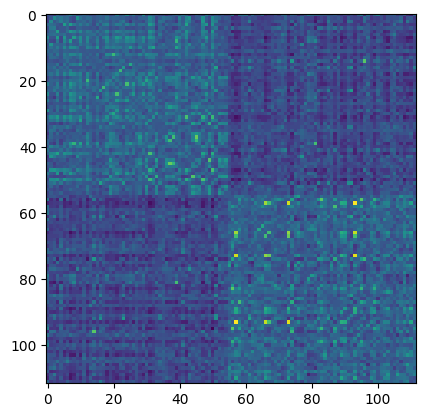

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.2118182794357399
p :  [0 1 2 0 2 2 0 2 1 0 1 1 2 3 1 3 3 0 2 3 2 0 1 1 3 2 0 2 3 3 0 3 3 1 3 2 2
 0 2 3 3 1 2 2 0 0 2 3 0 0 1 2 2 0 0 1 0 2 2 3 2 0 3 3 0 3 0 0 0 0 0 0 2 0
 0 2 1 1 2 3 0 2 3 1 0 0 2 2 3 1 0 3 2 2 2 3 3 1 1 0 0 2 2 0 0 3 0 0 3 1 2
 1]
k :  [  0  73  71  26  70  69  68  30  67  66  64  61  56  54  37  53  49  48
  74  45  21  80 107   3 106 104   6 103 100  99   9  90  85  84  17  44
  97  77  89  83  50  76 109  98  55 111  22  33  14  11  10   8  23   1
  41 101  20  43  81  18   2  86  87  92  93  75  12   4   5   7 102  94
  42  60  46  51  52  38  36 110  35  57  58  72  78  25  27  15 108  47
  40 105  39  28  29  31  79  16  19  96  95  82  59  65  91  13  34  88
  62  63  32  24]


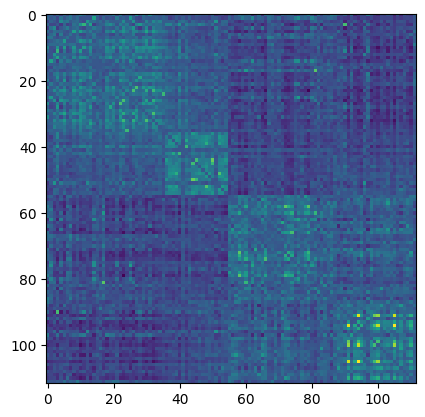

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.1917623126407438
p :  [1 2 4 0 5 5 0 5 3 0 3 2 4 7 2 6 6 0 5 6 5 0 2 2 6 5 0 4 7 7 1 7 7 2 6 5 4
 1 5 6 6 2 4 5 1 0 4 6 1 0 3 5 5 1 0 3 0 5 4 7 4 0 6 7 0 7 1 0 1 0 1 0 5 1
 0 5 3 2 4 6 1 4 6 2 0 0 4 5 6 2 1 6 5 4 4 7 7 3 2 1 0 4 5 0 1 7 0 0 6 3 4
 2]
k :  [ 85  69  64  71  21  74  61  17  56  54  84  26  67  49   9 100   6 103
  45   3 106 107  48  37  30  66  53   0  73  70  44  80  90  99 104  68
  77  83  89  98  41 111   1  11  14  22  23  33  76 109   8  10  97  55
  50  42  86  12  36  93  94  27  81  46  60  58   2 110 101  78   7  38
 102   5   4  92  43  87  35  52  18  57  75  20  72  25  51  16 108  39
  62  47  79  82  91  88  19  34  15  40  24  32 105  59  13  63  29  65
  28  96  31  95]


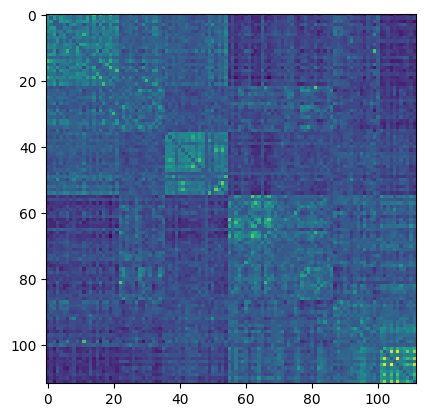

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.1804755235209323
p :  [ 2  4  8  0 10 10  0 10  7  0  6  4  8 15  4 12 13  0 11 13 11  1  4  4
 12 10  1  9 14 15  2 15 14  5 12 11  8  3 10 13 13  5  8 10  2  1  8 13
  2  1  6 11 11  2  1  6  0 11  9 14  8  1 13 14  1 14  2  0  3  0  3  0
 10  3  1 11  7  4  9 12  3  8 13  4  1  0  9 11 12  5  2 13 10  9  9 15
 15  6  5  2  1  8 11  1  3 15  1  0 12  6  8  4]
k :  [ 56 107   3  67   6  69   9  85  71  17  64  26  21  54  74  49  61  84
 100 103  45 106  48  44  90  99  30  66  53   0  73  70  80 104  68  37
  77  83 111  14  11  22  23   1  41  89  98  33  10  50  55  97 109  76
   8  81  12  42  36  60  46 101 110   2  94  93  27  58  78  86  38   7
   5  43  25   4  92  72 102  87  75  35  18  20  51  52  57  15 108  88
  24  34  79  40  47  39  62  91  19  16  82  28  59  32  63  65  29  31
 105  13  95  96]


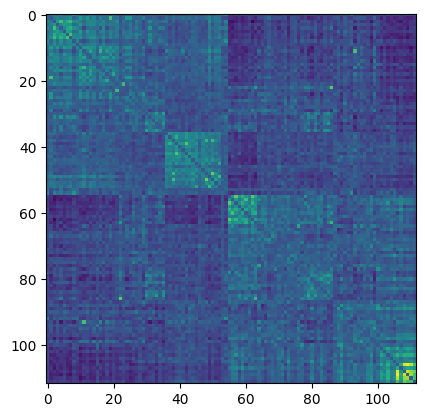

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.1966074722821281
p :  [ 5  8 17  0 20 20  0 20 14  0 13  8 17 31  9 25 26  1 23 27 23  2  9  9
 25 20  3 19 29 31  5 30 29 11 25 22 16  7 20 26 26 10 16 20  4  3 17 26
  4  3 12 22 22  5  3 13  1 23 19 29 17  2 27 29  2 28  4  0  6  0  6  1
 21  7  2 23 15  9 19 24  7 16 27  9  3  0 18 22 25 11  5 26 21 18 19 31
 31 13 10  5  3 16 23  2  7 31  2  0 25 12 17  9]
k :  [ 69  67 107   3  85   6   9  17  71  56 103  61  64 106  21  74  54  49
  84  45  26 100  66  48  44  30  90  99  53   0  68  70  73  80 104  37
  11   1  77  83 111  14  22  23  41  98  89  33 109  50  10  97  55   8
  76  81  42  36 101  12   2  46 110  60  86  93  94  27  58  78  38  43
   4  25   7   5  72  92  52  51  35  87  18  20  57 102  75  79 108  34
  24  15  88  91  47  16  40  39  62  82  19  65  28  63  59  32  31  96
  29 105  95  13]


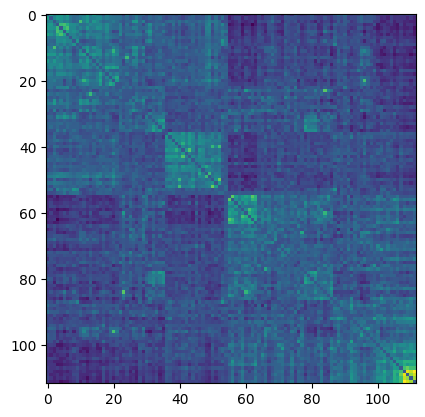

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -1.035221211347046
p :  [1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1
 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1
 0]
k :  [ 55  73  71  70  69  67  66  65  64  63  56  54  50  49  47  45  74  76
  77  78 109 107 106 103 102 100  99  44  96  90  89  85  84  83  80  79
  93  41 111  17   9  30   8  25  24   6  11  33  23  34  14  21   3   1
  10  82  12  81  15  86  87  88  13  39  92  16  95  97  98   7 101   5
   4 104 105   2 108  91  94  75  19  40  37  42  43  36  35  46  48  32
  51  52  53  31 110  57  58  59  60  61  62  29  28  27  26  68  22  72
  20  38  18   0]


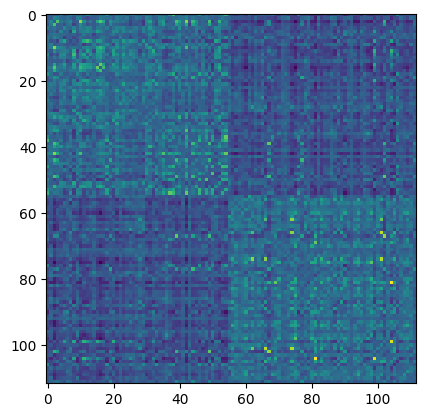

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -1.0109728853347346
p :  [3 0 2 1 2 2 1 2 0 1 0 0 3 3 0 3 2 1 3 3 3 1 2 0 0 0 2 2 3 3 0 2 3 0 0 3 3
 3 2 3 2 0 3 3 1 1 3 0 2 1 1 3 3 3 1 0 1 3 2 3 3 2 3 0 1 0 1 1 3 1 0 1 3 0
 1 3 1 0 1 0 1 3 3 0 1 1 3 3 3 0 1 2 2 0 2 3 0 2 2 1 1 3 1 1 3 3 1 0 2 1 2
 0]
k :  [ 55  25  30  33  34  41  47  63  65  70  73  77  79  83  89  93  96 107
  24  23 111   1  11  10   8  14  21  56  64  67  69   9  71  74  76  78
   6  80  84  85  90   3  99 100 102 103 106 109  54  50  66  45  49  17
  44  94  38  91   2  40  97  98  31  27  16   7  26  61   4  58   5 110
  48 108  22  92  88  51  28  95 101 104 105  18  19  29  87  81  32  52
  53  12  57  59  60  62  46  20  43  68  42  13  72  39  75  37  36  35
  15  82  86   0]


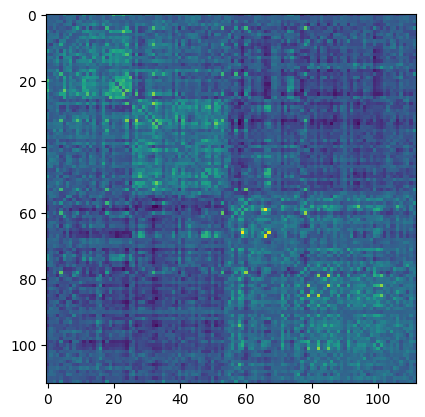

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.9779795332649194
p :  [1 0 5 2 5 5 2 4 0 2 0 0 6 6 0 7 5 3 7 7 7 2 5 0 1 0 4 5 6 6 1 4 6 0 1 7 7
 7 4 7 4 0 6 7 2 3 6 0 4 3 2 7 7 7 2 0 3 7 5 7 7 4 7 0 2 1 2 2 6 2 1 3 7 0
 3 6 3 0 3 0 3 7 6 0 2 2 7 7 6 0 2 5 5 0 5 6 0 4 5 2 4 7 3 2 7 6 2 0 5 2 5
 0]
k :  [ 55 107  96  93  89  83  79  77  73  63  47  41  33  25  23 111   8  10
   1  14  11  65  34  70  30   0  24  85 109  50  54  64 106  66 103  67
  69  99   3   6  84  90  44   9  21  74  45  17  71  49  78 102  80  56
  76  31  26  61   7  38 100  48  40  97  94  22  98  92  91   4  27   5
 108   2  16 110  58  75  46 105  95  29  13  88  42  32  12  82  68  28
  72  39  18  19  43 104  20  51 101  52  36  35  57  59  81  62  15  37
  87  86  53  60]


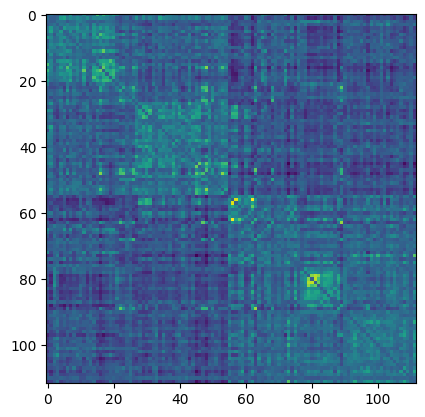

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.9955475596651102
p :  [ 6  1 10  5 10 11  5  8  1  5  1  1 13 13  1 15  8  6 15 14 14  4  9  1
  2  0  8 10 12 13  2  8 13  0  3 14 14 14  8 15  8  1  8 14  5  7 13  0
 10  7  4 14 14 15  4  1  7 14 11 15 14  8  8  0  4  2  5  4 13  5  2  7
 15  0  7 15  7  1  6  1  7 15 15  0  4  5 15 14 13  0  4 11  8  0 11 13
  0  9 10  4  4 14  7  4 14 13  5  0 10  4 10  1]
k :  [107  96  93  89  83  73  63  47  33  25  55  79  77  41  23 111  10  11
   1   8  14  65  70  24  30  34  99  50  54 109  64  67 100 103  84  90
  21   6  69  44  66 106  85   3   9  78   0  17  45  49 102  80  76  56
  74  71  26  92   7  38  40  62  31  16  61  42  97  22  48 108  27   4
   2  98 110  91   5  94  58  28  95  46  13  12  29  88  68 105  32  43
  20 104  19 101  87  52  60  37  36  51  57  35  72  53  81  82  59  18
  39  86  75  15]


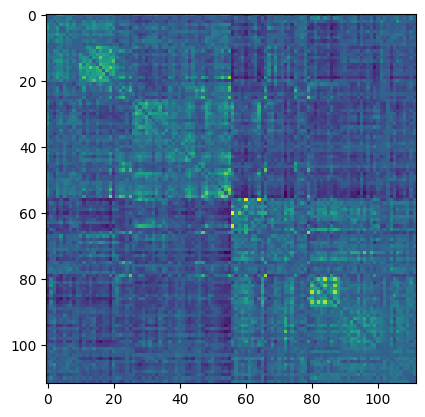

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -1.105888965824251
p :  [0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1
 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0
 1]
k :  [  0  37  75  39  40  95  42  43  94  93  46  47  48  92  91  36  51  53
 110  57  58  59  60  61  62  88  87  86  68  81  72  52  35  38  13   2
 108   4   5   7 105 104  12  97  14  15  16  18  78  20  32  31  98  29
  19  27  26  28  23 101  25 103  79  80 109 102  82  83  84 100 107  90
 106  99  89  85  96  55  76   1   3   6   8   9  10  11  17  21  22  24
  30  33  34  41  44  45  74  73  71  70  69  67  77  66  64  63  56  54
  50  49  65 111]


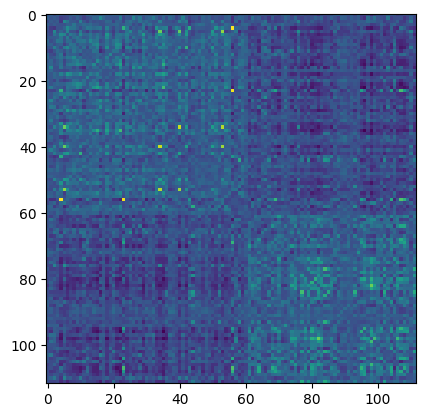

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -1.0774395158250252
p :  [0 3 0 2 0 0 2 1 3 3 3 3 1 1 3 0 1 2 0 0 0 2 3 0 3 0 1 0 1 1 3 1 1 2 3 0 0
 0 1 0 1 3 1 0 2 2 1 1 1 2 2 0 0 0 2 3 2 0 0 0 0 1 1 3 2 3 2 2 0 2 3 3 0 3
 2 0 2 3 0 3 3 1 3 3 2 2 0 0 1 3 2 0 1 0 1 1 3 1 1 2 2 0 3 2 0 1 2 3 1 2 1
 3]
k :  [  0  43  23  25  60  27  59  58  20 101  53  52  35  36  37  51  39  57
  19  87  86  91   2  18  78  93  75   5   4 104  15  68  72  48  47  46
  97 110  92  94  95  61  98  81  62  88  42  12 105 108  26  28  29  13
   7  31  38  40  32  16   6   3  90  84  85  76 106  74 109  67  56  99
  49  50 100  33  54  69  44 103  21  64  17  66  45 107  89 102  96  55
  82   1   8   9  10  11  14  22  24  30  34  41  63  65  70  71  73  77
  79  80  83 111]


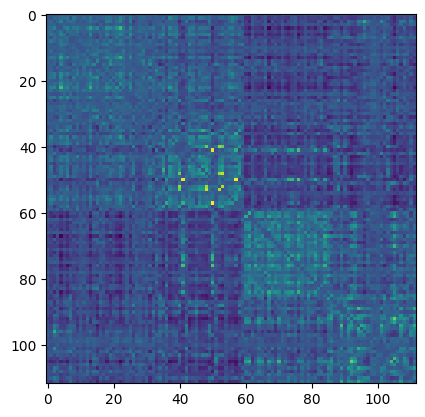

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -1.0559132134215208
p :  [1 6 0 4 1 1 5 3 7 7 6 6 2 2 1 1 3 5 1 1 0 4 6 1 6 1 3 1 2 2 6 3 2 5 6 1 1
 0 3 1 3 6 2 0 4 4 2 3 3 4 4 0 0 1 4 6 4 0 1 1 0 3 2 6 4 6 5 4 0 4 7 7 1 7
 4 0 4 6 1 7 6 3 7 6 5 5 0 0 2 7 4 1 2 1 3 2 7 3 3 5 4 1 6 4 0 2 5 7 3 4 2
 6]
k :  [ 43  87  75  68  60  57  52  51  37  20 104  86   2   0  58  59 101   4
  36  27  53  25  72  23  93  19  18  78  91  15  14  39   5  35 105  95
  62  46  92  88 110  42  12  28  29  13  32  31  98  26  16 108  97   7
  81  38  48  47  40  94  61 103  64  76  21  90 109  74  69  49  67  44
  45  50  56 100   3  54  84   6  17  33  99  66 106  85 102  55  41   1
  10  11  22  24  30  34  83  63 111  77  80  65  96  70  71  73  79   9
 107   8  89  82]


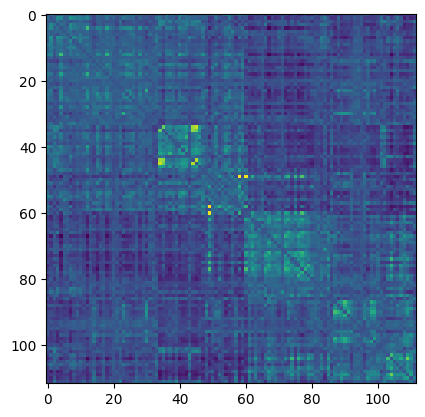

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -1.067833385617852
p :  [ 2 13  1  8  3  3 11  6 15 15 13 13  4  4  2  2  7 10  3  3  1  8 13  2
 12  2  6  2  5  4 12  7  4 11 12  3  3  0  7  2  6 13  4  1  8  9  4  7
  7  8  9  0  0  2  9 13  8  1  2  2  0  6  4 12  8 13 11  8  1  8 14 15
  2 15  9  1  9 13  2 15 12  7 15 13 11 11  1  0  4 15  8  3  4  3  7  4
 15  6  7 11  9  3 12  8  0  4 11 15  6  9  4 13]
k :  [ 87  51  37 104  60  52  68  20  43  57  75  86   2  23  25  39   0  14
  15  27  58  59  72  78  53 101  93  36  35  91  19   5  18   4  95  62
  29  12  13 110  46  42 105  32  92  88  28  26 108  97  40  61   7  31
  16  98  81  94  38  48  47  56  69  44  67  90  64  49 103   3  21  76
  74 109  45  50 100  54  17  33  85  84  99   6 106  66  63 102  24  34
  80  30  55  83   1  10  11  22  65  41  77 111  70  73  89  96  79   9
 107   8  82  71]


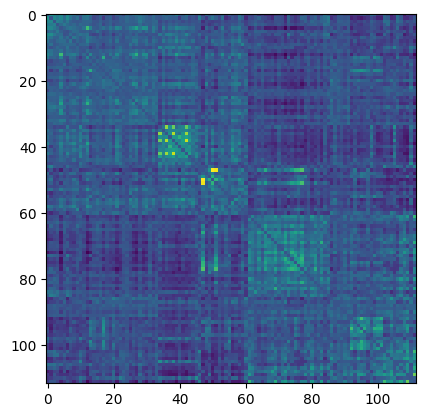

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.356389183497247
p :  [1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0
 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1
 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0
 1]
k :  [ 71  93  29  61  31  32  33  70  36  79  38  88  40  41  42  43  87  45
  57  48  84  50  56 110  81  26  54  76 109   2   3 108   6   7   8 106
  10 105  95  12  68  74  75  65 100  19  20  64  98  97  13  78  80  73
  77   0  83  85  86  89  91  92  94  96  99 101 102 103 104 107  82  90
  55  69  27  25  24  23  22  21  18  28  17  15  14  11   9   5   4   1
  16  72  30  35  67  66  63  62  60  59  58  34  53  51  49  47  46  44
  39  37  52 111]


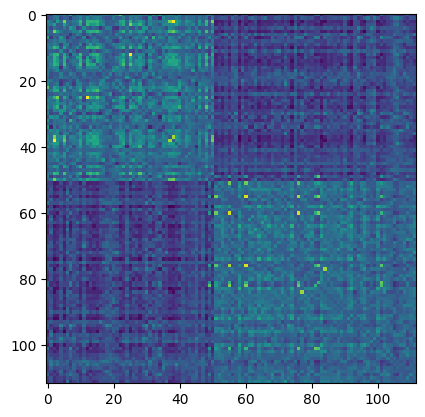

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.3054544366951834
p :  [2 3 1 1 3 3 1 1 1 3 0 3 0 1 3 3 3 2 3 1 0 3 3 3 2 3 0 3 2 0 2 1 0 0 2 3 1
 3 0 3 0 0 0 0 3 0 3 3 1 3 0 3 3 3 0 3 1 1 3 3 2 0 3 3 0 1 3 1 0 3 1 1 3 3
 0 0 1 3 2 0 3 1 3 3 0 3 3 0 1 3 3 2 3 0 3 1 3 0 0 3 0 3 3 3 2 1 1 3 0 0 0
 3]
k :  [ 38  20 100  87  98  97  26  50  29  45  43  32  33  42  41  40  93 110
  54  75  84  61  64  12 109  74  10  79 108  68  71  57  67  56  81  65
  88  70  48  76  36  95   2  31   3   6   7   8 106 105  13  19  78 104
  60  17   0  34  30  91  24  28 102  92 107  80  90  89  96  82  83  99
  86 103  94 101  85  55  73   1   4   5   9  11  14  15  16  18  21  22
  23  25  27  35  37  39  72  69  66  63  62  59  77  58  52  51  49  47
  46  44  53 111]


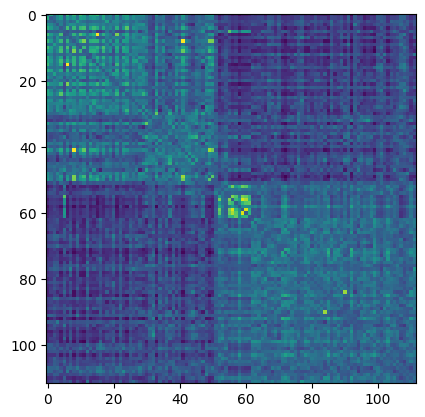

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.28290114785503107
p :  [4 6 3 2 7 7 2 3 3 7 0 6 0 3 6 7 6 4 6 3 0 7 6 6 4 6 0 7 5 0 5 3 0 1 5 6 3
 7 0 6 0 0 0 0 7 1 6 6 3 7 1 7 7 7 1 6 2 2 7 6 5 0 6 6 1 3 7 7 1 7 2 2 7 6
 1 0 2 6 4 1 7 3 6 6 1 7 7 1 2 6 7 4 6 0 6 3 6 1 0 7 1 6 6 7 5 2 2 6 0 0 0
 6]
k :  [ 93  43 110  26  12  42  10  98  41  29  40  75 108  38  32 109  61  20
  45  97  84 100  33  50  54  79  64  74  68  87  88  56  57  76  70  71
   3   6 106 105  36   2  65   7   8  13  48  81  31  19  95  78  91  24
   0  17 104  30  60  28  34  82  94  77 102  89 101 107  92  73  83  96
  55 111  35  22  39  46  47  18  16  23  25  11  59  62  63   1  14 103
   9   5  99  21   4  15  69  72  90  44  86  85  49  51  52  53  80  58
  66  67  27  37]


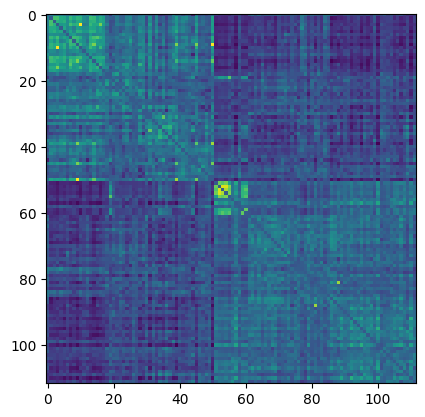

C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\4172466250.py:79: RuntimeWarning: divide by zero encountered in arctanh
  C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦


SCORE -0.30677076613730775
p :  [ 9 13  7  4 14 14  4  7  6 15  1 12  0  6 13 14 12  8 12  7  1 15 12 13
  9 12  1 14 10  1 10  7  1  2 11 12  7 15  1 13  1  1  0  1 15  3 13 12
  6 15  3 15 15 14  3 12  5  4 14 13 10  1 12 13  3  7 15 15  3 15  4  5
 15 12  3  0  4 12  9  2 14  6 12 13  3 15 14  3  4 12 14  9 13  0 13  6
 12  2  1 14  3 12 12 14 10  5  4 13  0  1  0 12]
k :  [ 42  93 108  75 110  12  29  43  40  26  20  98  41  38  32  61 109  10
  97  33  79  50  87  54  74  64  84  45  68 100  76  70   3  88  57 106
   6  56  71 105   8  81  13  48  95  36   2  31   7  65  19  17  91  78
  24   0 104  28  60  30  34  82 102 101  96  89  73  77  55 111  35  22
  18  16  11  47  62  25  14  92  46  83 107  39  63   1  23  94  59 103
  15  99   4   5  90  86  58  53  80  27  67  66  72   9  51  49  44  85
  21  37  52  69]


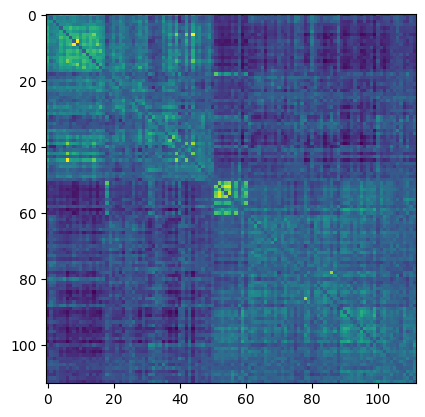

In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import scipy as sp

def get_cut(X):

    y = X
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    
    y2 = np.sum(y**2, axis=1, keepdims=True)/2

    y = np.hstack((y, y2, 0*y+1, y2 + 1))
    
    
    yX = np.matmul(y.T, X)

    
    minkowski = -np.ones((y.shape[1],1))
    minkowski[-1,0] = +1.0
 
    A = np.matmul(yX.T, minkowski*yX)
    
    Ao = np.expand_dims(A[:-1,-1],1)
    Aoo = A[-1,-1]
    A = A[:-1,:-1] - np.matmul(Ao, Ao.T)/Aoo
    
    
    lam, v = sp.linalg.eigh(A, eigvals=(0,0))
    v = np.vstack((v, -np.dot(Ao[:,0],v)/Aoo))
    
    
    c = np.matmul(X, v) > 0.0
    
    return c[:,0]

# X : c (112x112)
# X : 열 단위가 기저 벡터를 의미 
# max_depth : depth (int) tree의 깊이를 의미하는 것 같음
def otree_clusters(X, max_depth):
    # 1차원 0이 112개인 array 생성
    sets = np.zeros((X.shape[0])).astype(int)
    #print("sets : "  , sets)
    
    for k in range(max_depth):
        new_sets = 0*sets
        #print("new_sets : " , new_sets)
        for kk in range(np.max(sets)+1):
            #print("kk : ", kk)
            b = sets==kk
            #print("b : ", b)
            Xs = X[b, :]
            #print("Xs : "  , Xs)
            
            c = get_cut(Xs)
            #print("c : "  , c)
            
            new_sets[b] = 2*sets[b] + c
            #print("new_sets[b] : "  , new_sets[b])
        sets = new_sets
        #print("sets : "  , sets)
    return sets


# x : train_binned['lr1'] (array)
def get_clusters(x, depth=3):  
    # 결측치를 평균 값으로 대체
    x[~np.isfinite(x)] = np.mean(x[np.isfinite(x)])

    # x : (3830, 112)
    x = x - np.nanmean(x, 0) # 열 평균을 뺀 값 계산
    x = x / (np.nanstd(x, 0)+1e-20)     # 표준 편차로 나누어 정규화

    # 각 주식간의 피어슨 상관계수 계산 (-1 ~ +1)
    # 관측결과 음수로 떨어지는 경우는 최소 8건 많으면 322건
    # x가 같은 데이터 인 경우 당연히 C 값은 같음
    C = np.corrcoef(x.T)
    C = np.arctanh(C) # 상관계수의 분포를 정규 분포에 가깝게 만듦
    a = np.arange(C.shape[0])
    C[a,a] = 0 # 대각행렬의 값은 0
    
    # stock id 마다의 상관계수 평균 값
    # e.g. m[0] stock_id 0를 포함한 나머지 112개의 stock_id 와의 상관계수의 평균
    m = np.mean(C, 1, keepdims=True)
    # 평균 값을 빼줌으로써 더 정확한 상관관계를 계산
    C = C - (m + m.T)
    
    # 대각 행렬은 평균 값으로 변환
    C[a,a] = np.mean(C)

    pca = PCA(x.shape[1]) # 112
    pca.fit(x)
    
    # pca.components_.shape 112 x 112 : x를 잘 설명하는 기저 축
    # pca.components_의 모든 벡터 사이즈는 1로 같음
    # pca.singular_values_ : 주 성분들의 분산 값으로 구성된 1차원 배열
    # pca.singular_values_ 의 sqrt 값 (std)을 곱함
    c = pca.components_ * pca.singular_values_[:,np.newaxis]**.5
    
    # pca.singular_values_ i번째 값을 pca.components_ i번째 행 모든 값에 곱함
    c = c.T # 전치 결과 열 단위가 기저 벡터를 의미

    p = otree_clusters(c, depth) 
    
    #tmp_c = p

    #print("p.shape" , p.shape) #(112,)
    #print(p)
    means = []    
    for k in range(np.max(p)+1):
        mn = np.mean(c[p==k, :], 0)
        means.append(mn)
    means= np.vstack(means)
    
    gm = GaussianMixture(means.shape[0], means_init=means, weights_init=np.ones(means.shape[0])/means.shape[0], covariance_type='full', 
                         precisions_init=np.repeat( np.eye(means.shape[1])[np.newaxis,:,:]/means.shape[1], repeats=means.shape[0], axis=0) )
                             
    p = gm.fit_predict(c)
    
    #print("is it same?? : ", p)    
    _, cnts = np.unique( p, return_counts=True)
    #print(cnts)

    score=0
    nc= np.max(p)+1
    for k in range(nc):
        Q =  C[p==k,:][:,p==k]
        score += np.mean(Q)/nc
    print('SCORE', score)
    
    
    k = np.argsort(p)
    print("p : ",p)
    print("k : ",k)
    plt.imshow( (C[k,:][:,k]) )
    plt.show()

    return p

def high_corr_set(x, q):  
    x[~np.isfinite(x)] = np.mean(x[np.isfinite(x)])

    x = x - np.nanmean(x, 0)
    x = x / np.nanstd(x, 0)
    
    C = np.corrcoef(x.T)
    c = np.median(C, 1)
    
    b = c > np.quantile(c,q)
    
    idxs =  np.arange(c.shape[0])[b]

    return idxs


rvol   = train_binned['root_volume']
vol    = train_binned['volume']
vol1   = train_binned['vol1']
lr1   = train_binned['lr1']
lsprd  = train_binned['log_spread']
r4liq3 = train_binned['liquidity3_4th_root']
liq2   = train_binned['liquidity2']

lr1 = np.mean(lr1,2)
vol1 = np.mean(vol1**2, 2)**.5
tvpl3 = np.log(np.mean( rvol, 2)**(1/2)/np.mean( (r4liq3[:,:, 0:]), 2)**(4/3))
rvol = np.log(np.mean(rvol**.5,2))
lsprd = (np.mean(lsprd,2))
vol1 = np.log(vol1)
vol = (np.mean(vol,2) )

# log return
lr1_clusters1 = get_clusters(lr1, depth=1)
lr1_clusters2 = get_clusters(lr1, depth=2)
lr1_clusters3 = get_clusters(lr1, depth=3)
lr1_clusters4 = get_clusters(lr1, depth=4)
lr1_clusters5 = get_clusters(lr1, depth=5)

lr1_hc = high_corr_set(lr1, .9)

tvpl3_clusters1 = get_clusters(tvpl3, depth=1)
tvpl3_clusters2 = get_clusters(tvpl3, depth=2)
tvpl3_clusters3 = get_clusters(tvpl3, depth=3)
tvpl3_clusters4 = get_clusters(tvpl3, depth=4)

vol1_clusters1 = get_clusters(vol1, depth=1)
vol1_clusters2 = get_clusters(vol1, depth=2)
vol1_clusters3 = get_clusters(vol1, depth=3)
vol1_clusters4 = get_clusters(vol1, depth=4)

vol1_hc = high_corr_set(vol1, .95)

vol_clusters1 = get_clusters(rvol, depth=1)
vol_clusters2 = get_clusters(rvol, depth=2)
vol_clusters3 = get_clusters(rvol, depth=3)
vol_clusters4 = get_clusters(rvol, depth=4)


del rvol, vol, vol1, lr1, lsprd, r4liq3, liq2



## Features

In [6]:

def nancorr(a, b):
    v = np.isfinite(a)*np.isfinite(b) > 0
    return np.corrcoef(a[v], b[v])[0,1]


def plot_by_sid(train, x, y):
    for u in np.unique(train['stock_id']):
        b = train['stock_id']==u
        plt.plot(x[b], y[b], '.', markersize=1)
    plt.show()
    
    
def cluster_agg(x, clusters, agg_fun):
    r = 0*x
    
    for k in range(np.max(clusters)+1):
        z = agg_fun(x[:,clusters==k,:], 1, keepdims=True)
        r[:,clusters==k,:] = np.repeat(z, repeats=int(np.sum(clusters==k)), axis=1)
    return r
    

def keys_to_array(d, features):
    
    sh = np.max( [d[f].shape[1] for f in features] )
    sq = np.max( [d[f].shape[0] for f in features] )
    
    for f in features:
        if d[f].shape[1]==1:
            d[f] = np.repeat(d[f], repeats=sh, axis=1)
        if d[f].shape[0]==1:
            d[f] = np.repeat(d[f], repeats=sq, axis=0)
        
    
    stack = [d[feature] for feature in features]
    
    X = np.dstack(stack)
    
    return X


def merge_features_to_df(fdict, df, features):
    sids = df['stock_id'].unique()

    T = fdict['time_ids'][:,:,0]
    S = fdict['stock_ids'][:,:,0]

    T = np.reshape(T, [T.shape[0]*T.shape[1]])
    S = np.reshape(S, [S.shape[0]*S.shape[1]])
    
    sh = np.max( [fdict[f].shape[1] for f in features] )
    sq = np.max( [fdict[f].shape[0] for f in features] )
    
    for f in features:
        if fdict[f].shape[1]==1:
            fdict[f] = np.repeat(fdict[f], repeats=sh, axis=1)
        if fdict[f].shape[0]==1:
            fdict[f] = np.repeat(fdict[f], repeats=sq, axis=0)
        
    
    reshaped_features = [np.reshape( fdict[feature], [fdict[feature].shape[0]*fdict[feature].shape[1]] )
                         for feature in features]


    
    dfz = pd.DataFrame(data=np.vstack([S,T] + reshaped_features  ).T, columns=['stock_id', 'time_id']+features)
    dfz['time_id' ] = dfz['time_id' ].astype(int)
    dfz['stock_id'] = dfz['stock_id'].astype(int)

    dfz = df.merge(dfz, on=['stock_id', 'time_id'], how='left')
    return dfz


def get_simple_features(binned_features, final_features, name, ffrom=0):
    v = binned_features[name]

    suffix = f'_from_{ffrom}'

    s  = np.mean(np.mean(v**2, (2), keepdims=True)**.5, 0, keepdims=True)

    final_features[name + suffix] =            np.log(             np.mean(v[:,:,ffrom:]**2, 2, keepdims=True)**0.5/final_features['vol1'])
    final_features[name+'stock_mean'+suffix] = np.log(s*np.median( np.mean( v[:,:,ffrom:]/s, 2, keepdims=True), 1, keepdims=True)/final_features['vol1'])

    

def get_cohesion_features(binned_features, final_features, ffrom=0):
    # ffrom 0, 10 20
    lr1 = binned_features['lr1']

    if ffrom > 0: 
        suffix = f'_from_{ffrom}'
    else:
        suffix = ''
    # 3830 x 112 x 1  (1, 112)
    # 112 개의 주식의 3830개 데이터의 분산을 구하고 (1, 112, 30) 30개를 평균 => (1, 112) 후, sqrt 
    s = np.mean( np.var(lr1, 0,keepdims=True), 2, keepdims=True)**0.5
    # 특정 bin 시점(ffrom) 이후 데이터만 따로 분리 한 후, 각 주식의 std 값으로 나눔
    qs = lr1[:,:,ffrom:]/s # shape : 3830 x 112 x 30-ffrom

    final_features['tbin_var'               + suffix] = s*np.mean(  np.var( qs, 1, keepdims=True)         , 2, keepdims=True)**0.5/final_features['vol1']
    final_features['market_var'             + suffix] = s*np.mean( (np.mean(qs, 1, keepdims=True)     )**2, 2, keepdims=True)**0.5/final_features['vol1']
    final_features['deviations_from_market' + suffix] = s*np.mean( (np.mean(qs, 1, keepdims=True) - qs)**2, 2, keepdims=True)**0.5/final_features['vol1']
    
    



def get_misc_features(binned_features, final_features):
    
    # shape 3830,112,30    
    vol    = binned_features['volume']
    vol1    = binned_features['vol1']

    rvol   = binned_features['root_volume']

    liq2   = binned_features['liquidity2']
    liq3   = binned_features['liquidity3']
    r4liq3 = binned_features['liquidity3_4th_root']
    lsprd  = binned_features['log_spread2']
    
    # shape 1,112,1
    s  = np.nanmean( vol, (0,2), keepdims=True)
    sr = np.nanmean(rvol, (0,2), keepdims=True)
    l2 = np.nanmean(liq2, (0,2), keepdims=True)
    l3 = np.nanmean(liq3, (0,2), keepdims=True)
    # shape 3830,112,1
    v1 = np.nanmean(vol1**2, 2, keepdims=True)**.5
    
        
    final_features['soft_stock_mean_tvpl2'    ] = np.log( (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_f10'] = np.log( (s/l2*np.nanmean( (vol[:,:,10:]/liq2[:,:,10:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_f20'] = np.log( (s/l2*np.nanmean( (vol[:,:,20:]/liq2[:,:,20:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    
    final_features['soft_stock_mean_tvpl3'    ] = np.log( (sr/l3*np.nanmean( (rvol[:,:, 0:]/liq3[:,:, 0:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_f10'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,10:]/liq3[:,:,10:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_f20'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,20:]/liq3[:,:,20:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    
    final_features['soft_stock_mean_tvpl2_liqf'       ] = np.log( (s/l2*np.nanmean( (vol[:,:, 0:]/liq2[:,:,-1:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_liqf_volf10'] = np.log( (s/l2*np.nanmean( (vol[:,:,10:]/liq2[:,:,-1:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    final_features['soft_stock_mean_tvpl2_liqf_volf20'] = np.log( (s/l2*np.nanmean( (vol[:,:,20:]/liq2[:,:,-1:]*l2/s)**(1/8), (1,2), keepdims=True)**8)**.5/v1)
    
    final_features['soft_stock_mean_tvpl3_liqf'       ] = np.log( (sr/l3*np.nanmean( (rvol[:,:, 0:]/liq3[:,:,-1:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_liqf_volf10'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,10:]/liq3[:,:,-1:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    final_features['soft_stock_mean_tvpl3_liqf_volf20'] = np.log( (sr/l3*np.nanmean( (rvol[:,:,20:]/liq3[:,:,-1:]*l3/sr)**(1/8), (1,2), keepdims=True)**8)**(1/3)/v1)
    
    

    tvpl3     = np.log( np.mean( rvol, 2, keepdims=True)**(1/2)/np.mean( (r4liq3[:,:, 0:]), (2), keepdims=True)**(4/3)/v1)
    tvpl3lf20 = np.log( np.mean( rvol, 2, keepdims=True)**(1/2)/np.mean( (r4liq3[:,:, 20:]), (2), keepdims=True)**(4/3)/v1)
    
    final_features['tvpl3_rmed2v1']     = np.log( np.median(tvpl3/v1,1, keepdims=True)    )
    final_features['tvpl3_rmed2v1lf20'] = np.log( np.median(tvpl3lf20/v1,1, keepdims=True))    
    
    final_features['v1proj_25_15'] = np.log( np.nanmedian( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                         / np.mean(vol1[:,:,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )
        
    final_features['v1proj_25_15_lr1_hc'] = np.log( np.nanmedian( np.mean(vol1[:,lr1_hc,25:]**2,2,keepdims=True)
                                                                / np.mean(vol1[:,lr1_hc,:15]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    final_features['v1proj_25_15_vol1_hc'] = np.log( np.nanmedian( np.mean(vol1[:,vol1_hc,25:]**2,2,keepdims=True)
                                                                 / np.mean(vol1[:,vol1_hc,:15]**2,2,keepdims=True),1,keepdims=True)**.5 ) 
    final_features['v1proj_25_lr1_hc']     = np.log( np.nanmedian( np.mean(vol1[:,lr1_hc,25:]**2,2,keepdims=True)
                                                             / np.mean(vol1[:,lr1_hc,:]**2,2,keepdims=True),1,keepdims=True)**.5 )
    final_features['v1proj_25_vol1_hc']    = np.log( np.nanmedian( np.mean(vol1[:,vol1_hc,25:]**2,2,keepdims=True)
                                                              / np.mean(vol1[:,vol1_hc,:]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    
    final_features['lsvol'] = np.log( np.nanmean(binned_features['lsvol'], 2, keepdims=True))    

    final_features['liqvol1'] = np.log( np.nanmean(binned_features['liqvol1'], 2, keepdims=True))    
    final_features['liqvol1_smean'] = np.log( np.nanmean(binned_features['liqvol1'], (1,2), keepdims=True))    

    final_features['liqvol1_smean_c3'] = np.log( cluster_agg(np.nanmean(binned_features['liqvol1'], 2, keepdims=True), lr1_clusters3,np.nanmedian))    

    
    
    final_features['liqvol2'] = np.log( np.nanmean(binned_features['liqvol2'], 2, keepdims=True))    
    final_features['liqvol3'] = np.log( np.nanmean(binned_features['liqvol3'], 2, keepdims=True))    

    
    final_features['liqvol1_15_15'] = np.log( np.nanmean(binned_features['liqvol1'][:,:,15:  ], 2, keepdims=True)
                                            /np.nanmean(binned_features['liqvol1'][:,:,  :15], 2, keepdims=True))    

    final_features['trade_count']      = np.log( np.nanmean(binned_features['trade_count']    , 2, keepdims=True))    
    final_features['root_trade_count'] = np.log( np.nanmean(binned_features['trade_count']**.5, 2, keepdims=True))    
    final_features['root_book_delta_count'] = np.log( np.nanmean(binned_features['book_delta_count']**.5, 2, keepdims=True))    

    final_features['root_trade_count_smean'] = np.log( np.nanmean(binned_features['trade_count']**.5, (1,2), keepdims=True))    

    final_features['root_trade_count_smean_c1'] = np.log( cluster_agg(np.nanmean(binned_features['trade_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters1,np.nanmean))
    final_features['root_trade_count_smean_c2'] = np.log( cluster_agg(np.nanmean(binned_features['trade_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters2,np.nanmean))
    final_features['root_trade_count_smean_c3'] = np.log( cluster_agg(np.nanmean(binned_features['trade_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters3,np.nanmean))    
    final_features['root_trade_count_var'] = np.log( np.nanvar(binned_features['trade_count']**.5, 2, keepdims=True))    

    
    final_features['root_book_delta_count_smean'] = np.log( np.nanmean(binned_features['book_delta_count']**.5, (1,2), keepdims=True))    

    final_features['root_book_delta_count_smean_c1'] = np.log( cluster_agg(np.nanmean(binned_features['book_delta_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters1,np.nanmean))
    final_features['root_book_delta_smean_c2'] = np.log( cluster_agg(np.nanmean(binned_features['book_delta_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters2,np.nanmean))
    final_features['root_book_delta_count_smean_c3'] = np.log( cluster_agg(np.nanmean(binned_features['book_delta_count']**0.5, 2, keepdims=True),
                                                                     lr1_clusters3,np.nanmean))    
    final_features['root_book_delta_count_var'] = np.log( np.nanvar(binned_features['book_delta_count']**.5, 2, keepdims=True))    

    
    
    final_features['trade_count_15_15']      = np.log( np.nanmean(binned_features['trade_count'][:,:,15:  ], 2, keepdims=True)/
                                                      np.nanmean(binned_features['trade_count'][:,:,  :15], 2, keepdims=True))    
    final_features['root_trade_count_15_15'] =  np.log( np.nanmean(binned_features['trade_count'][:,:,15:  ]**.5, 2, keepdims=True)/
                                                       np.nanmean(binned_features['trade_count'][:,:,  :15]**.5, 2, keepdims=True)) 
    
    
    final_features['v1proj_29_15'] = np.log( np.nanmedian( np.mean(vol1[:,:,29:  ]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,  :15]**2,2,keepdims=True),1,keepdims=True)**.5)
    final_features['v1proj_20']    = np.log( np.nanmedian( np.mean(vol1[:,:,20:  ]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )   
    final_features['v1proj_25']    = np.log( np.nanmedian( np.mean(vol1[:,:,25:  ]**2,2,keepdims=True) 
                                                        / np.mean(vol1[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )
    final_features['v1proj_29']    = np.log( np.nanmedian( np.mean(vol1[:,:,28:  ]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,  :  ]**2,2,keepdims=True),1,keepdims=True)**.5 )
    
    final_features['v1proj_29_q1'] = np.log( np.quantile( np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_29_q3'] = np.log( np.quantile( np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    final_features['v1proj_25_q1'] = np.log( np.quantile( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_25_q3'] = np.log( np.quantile( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                        / np.mean(vol1[:,:,:  ]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 ) 
    
    final_features['v1proj_29_15_q1'] = np.log( np.quantile( np.mean(vol1[:,:,28:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_29_15_q3'] = np.log( np.quantile( np.mean(vol1[:,:,28:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    final_features['v1proj_25_15_q1'] = np.log( np.quantile( np.mean(vol1[:,:,25:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.25, 1,keepdims=True)**.5 )
    final_features['v1proj_25_15_q3'] = np.log( np.quantile( np.mean(vol1[:,:,25:  ]**2,2,keepdims=True)
                                                           / np.mean(vol1[:,:,  :15]**2,2,keepdims=True), 0.75, 1,keepdims=True)**.5 )
    
    
      
    
    
    
    
    final_features['v1proj_25_15_std'] = np.log( np.nanstd( np.log( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                               / np.mean(vol1[:,:,:15]**2,2,keepdims=True)),1,keepdims=True)**.5 )
    final_features['v1proj_29_15_std'] = np.log( np.nanstd( np.log( np.mean(vol1[:,:,29:]**2,2,keepdims=True)
                                                               / np.mean(vol1[:,:,:15]**2,2,keepdims=True)),1,keepdims=True)**.5 )
    
    final_features['v1proj_20_std'] = np.log( np.nanstd( np.log(np.mean(vol1[:,:,20:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,1,keepdims=True) )
    final_features['v1proj_25_std'] = np.log( np.nanstd( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,1,keepdims=True) )
    final_features['v1proj_29_std'] = np.log( np.nanstd( np.log(np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,1,keepdims=True) )
    
    
    final_features['v1proj_29_q3q1'] = np.log(np.quantile( np.log(np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,0.75, axis=1,keepdims=True)
                                                -
                                                np.quantile( np.log(np.mean(vol1[:,:,28:]**2,2,keepdims=True)
                                                            /np.mean(vol1[:,:,:  ]**2,2,keepdims=True))
                                                    ,0.25, axis=1,keepdims=True))
    
    if vol1.shape[1]>100:
        final_features['v1proj_25_c1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters1, np.median)**0.5 )  
        final_features['v1proj_25_c2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters2, np.median)**0.5 )
        final_features['v1proj_25_c3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters3, np.median)**0.5 )
        final_features['v1proj_25_c4'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters4, np.median)**0.5 )
        final_features['v1proj_25_c5'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        lr1_clusters5, np.median)**0.5 )
        
  

        final_features['soft_stock_mean_tvpl2_c1'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters1, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_c2'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters2, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_c3'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 0:]/liq2[:,:, 0:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters3, np.mean)**8**.5/v1)
        
        final_features['soft_stock_mean_tvpl2_10_c1'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 10:]/liq2[:,:,10:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters1, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_10_c2'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 10:]/liq2[:,:,10:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters2, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_10_c3'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 10:]/liq2[:,:,10:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters3, np.mean)**8**.5/v1)
        
        final_features['soft_stock_mean_tvpl2_20_c1'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 20:]/liq2[:,:,20:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters1, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_20_c2'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 20:]/liq2[:,:,20:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters2, np.mean)**8**.5/v1)
        final_features['soft_stock_mean_tvpl2_20_c3'] = np.log( s/l2*cluster_agg(
            np.nanmean( (vol[:,:, 20:]/liq2[:,:,20:]*l2/s)**(1/8), 2, keepdims=True),
                lr1_clusters3, np.mean)**8**.5/v1)

        
        final_features['v1proj_25_c1_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters1, np.nanstd)**0.5  )  
        final_features['v1proj_25_c2_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters2, np.nanstd)**0.5 )
        final_features['v1proj_25_c3_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters3, np.nanstd)**0.5 )
        final_features['v1proj_25_c4_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters4, np.nanstd)**0.5 )
        final_features['v1proj_25_c5_std'] = np.log( cluster_agg( np.log(np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True)),
                                                        lr1_clusters5, np.nanstd)**0.5 )
        
        
        final_features['v1proj_25_vc1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_vc2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters2, np.median)**0.5 )
        final_features['v1proj_25_vc3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters3, np.median)**0.5 )
    
        final_features['v1proj_25_vc4'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol1_clusters4, np.median)**0.5 )

        
        final_features['v1proj_25_tc1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_tc2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters2, np.median)**0.5 )
        final_features['v1proj_25_tc3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters3, np.median)**0.5 )
        final_features['v1proj_25_tc4'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        tvpl3_clusters4, np.median)**0.5 )

        final_features['v1proj_25_vvc1'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol_clusters1, np.median)**0.5  )  
        final_features['v1proj_25_vvc2'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol_clusters2, np.median)**0.5 )
        final_features['v1proj_25_vvc3'] = np.log( cluster_agg( np.mean(vol1[:,:,25:]**2,2,keepdims=True)
                                                       / np.mean(vol1[:,:,:  ]**2,2,keepdims=True),
                                                        vol_clusters3, np.median)**0.5 )

        
        
        final_features['v1spprojt15f25_c1'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters1, np.median) )
        final_features['v1spprojt15f25_c2'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters2, np.median) )
        final_features['v1spprojt15f25_c3'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters3, np.median) )
        final_features['v1spprojt15f25_c4'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           lr1_clusters4, np.median) )

        final_features['v1spprojt15f25_vc1'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           vol1_clusters1, np.median) )
        final_features['v1spprojt15f25_vc2'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           vol1_clusters2, np.median) )
        final_features['v1spprojt15f25_vc3'] = np.log( cluster_agg( 
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True),
                           vol1_clusters3, np.median) )  
    
    
    final_features['tvpl3_rmed2v1'] = np.log( np.median( 
                                        np.mean( rvol           , 2, keepdims=True)**(1/2)/
                                        np.mean( r4liq3[:,:, 0:], 2, keepdims=True)**(4/3)/v1,
                                            1, keepdims=True) )
    final_features['tvpl3_rmed2v1_29'] = np.log( np.median( 
                                                np.mean( rvol           , 2, keepdims=True)**(1/2)/
                                                np.mean( r4liq3[:,:, 29:], 2, keepdims=True)**(4/3)/v1,
                                            1, keepdims=True) )

    
    final_features['tvpl2_rmed2v1']     = np.log( np.median( ( np.mean( vol              , 2, keepdims=True)**.5
                                                    / np.mean( liq2[:,:, 0:]**.5, 2, keepdims=True))/v1, 1, keepdims=True))
    final_features['tvpl2_rmed2v1lf25'] = np.log( np.median(( np.mean( vol, 2, keepdims=True)**.5
                                                    / np.mean( (liq2[:,:, 25:])**.5, (2), keepdims=True))/v1, 1, keepdims=True))
    final_features['tvpl2_rmed2v1lf29'] = np.log( np.median(( np.mean( vol, 2, keepdims=True)**.5
                                                    / np.mean( (liq2[:,:, 29:])**.5, (2), keepdims=True))/v1, 1, keepdims=True))
    
    
    
    ###
    final_features['tvpl2']        = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2)**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_liqf10'] = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2[:,:,10:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_liqf20'] = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2[:,:,20:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_liqf29'] = np.log( np.mean( vol, 2, keepdims=True)**.5/np.mean( (liq2[:,:,29:])**.5, (2), keepdims=True)/v1)

    final_features['tvpl2_smean_vol'       ] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:, 0:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_smean_vol_liqf10'] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:,10:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_smean_vol_liqf20'] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:,20:])**.5, (2), keepdims=True)/v1)
    final_features['tvpl2_smean_vol_liqf29'] = np.log( np.mean( vol, (0,2), keepdims=True)**.5/np.mean( (liq2[:,:,29:])**.5, (2), keepdims=True)/v1)
    
    
    final_features['tvpl3'       ] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:, 0:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_liqf10'] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:,10:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_liqf20'] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:,20:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_liqf29'] = np.log(np.mean( rvol, 2, keepdims=True)/np.mean( (r4liq3[:,:,29:]), (2), keepdims=True)**(4/3)/v1)

    final_features['tvpl3_smean_vol'       ] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:, 0:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_smean_vol_liqf10'] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:,10:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_smean_vol_liqf20'] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:,20:]), (2), keepdims=True)**(4/3)/v1)
    final_features['tvpl3_smean_vol_liqf29'] = np.log(np.mean( rvol, (0,2), keepdims=True)**.5/np.mean( (r4liq3[:,:,29:]), (2), keepdims=True)**(4/3)/v1)


    
    
    
    final_features['v1liq2projt5'] = np.log( ( np.mean( liq2[:,:,  : 5]**(1/8), 2, keepdims=True)**8
                                            / np.mean( liq2[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )
    final_features['v1liq3projt5'] = np.log( ( np.mean( liq3[:,:,  : 5]**(1/8), 2, keepdims=True)**8
                                            / np.mean( liq3[:,:,28:  ]       , 2, keepdims=True) )**(1/3) )
    
    final_features['v1liq2projt10'] = np.log( ( np.mean( liq2[:,:,  :10]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq2[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )
    final_features['v1liq3projt10'] = np.log( ( np.mean( liq3[:,:,  :10]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq3[:,:,28:  ]       , 2, keepdims=True) )**(1/3) )
    
    final_features['v1liq2projt20'] = np.log( ( np.mean( liq2[:,:,  :20]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq2[:,:,28:  ]       , 2, keepdims=True) )**(1/2) )
    final_features['v1liq3projt20'] = np.log( ( np.mean( liq3[:,:,  :20]**(1/8), 2, keepdims=True)**8
                                             / np.mean( liq3[:,:,28:  ]       , 2, keepdims=True) )**(1/3) )
    
    final_features['liqt10rf29'] = np.log( np.mean( liq2[:,:,:10]**.5, (2), keepdims=True)**2 / liq2[:,:,29:] )
    final_features['liqt20rf29'] = np.log( np.mean( liq2[:,:,:20]**.5, (2), keepdims=True)**2 / liq2[:,:,29:] )
    
    
    final_features['v1liq2sprojt10f25'] = np.log( np.median(
                          np.mean(liq2[:,:,  :10]**.125, (2),keepdims=True)**8/
                          np.mean(liq2[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/2) )
    final_features['v1liq2sprojt5f25'] = np.log( np.median(
                          np.mean(liq2[:,:,  : 5]**.125, (2),keepdims=True)**8/
                          np.mean(liq2[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/2) )
    final_features['v1liq3sprojt15f25'] = np.log( np.median(                 
                          np.mean(liq3[:,:,  :15]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/3) )
    final_features['v1liq3sprojt5f25'] = np.log( np.median(
                          np.mean(liq3[:,:,  : 5]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/3) )
    
    final_features['v1liq3projt15f25'] = np.log( (
                          np.mean(liq3[:,:,  :15]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                           )**(1/3) )
    
    final_features['v1liq3sprojt10f25'] = np.log( np.median(
                          np.mean(liq3[:,:,  :  ]**.125, (2),keepdims=True)**8/
                          np.mean(liq3[:,:,25:  ]**.125, (2),keepdims=True)**8
                        , 1, keepdims=True)**(1/3) )
    
    final_features['v1spprojt10f29'] = np.median(
                          - np.mean(lsprd[:,:,  :  ], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:  ], (2),keepdims=True)
                                    , 1, keepdims=True)
    final_features['v1spprojt15f25'] = np.median(
                          - np.mean(lsprd[:,:,  :15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:  ], (2),keepdims=True)
                           , 1, keepdims=True)
    
    final_features['v1spprojt15f29'] = np.median(
                          - np.mean(lsprd[:,:,  :15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:  ], (2),keepdims=True)
                                    , 1, keepdims=True)

    final_features['v1spprojt15f29_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojt15f29_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    final_features['v1spprojt15f25_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojt15f25_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:15], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    
    final_features['v1spprojtf29_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojtf29_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,29:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    
    final_features['v1spprojtf25_q1'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.25, 1, keepdims=True)
    final_features['v1spprojtf25_q3'] = np.quantile(
                          - np.mean(lsprd[:,:,:], (2),keepdims=True)
                          + np.mean(lsprd[:,:,25:], (2),keepdims=True)
                                    ,0.75, 1, keepdims=True)
    
    
def read_targets_from_df(df, s, t):
    t = list(t)
    s = list(s)
    
    
    Z = np.zeros((len(t), len(s)))
    
    dft = np.array(df['time_id'])
    dfs = np.array(df['stock_id'])
    dfr = np.array(df['target'])
    
    
    for k in range(df.shape[0]):
        Z[t.index(dft[k]), s.index(dfs[k])] = dfr[k]
    return Z
    
    

def get_features(binned_features):
    final_features = {}

    final_features[ 'time_ids'] = (1*binned_features['time_ids'][:,np.newaxis] + 0*binned_features['stock_ids'][np.newaxis,:])[:,:,np.newaxis]
    final_features['stock_ids'] = (0*binned_features['time_ids'][:,np.newaxis] + 1*binned_features['stock_ids'][np.newaxis,:])[:,:,np.newaxis]

    # 각 특징의 값들을 제곱 후 , 루트
    final_features['vol1'] = np.mean(binned_features['vol1']**2, 2, keepdims=True)**0.5
    final_features['cvol1'] = np.log(np.mean(binned_features['cvol1']**2, 2, keepdims=True)**0.5/final_features['vol1'])
    final_features['evol1'] = np.log(np.mean(binned_features['evol1']**2, 2, keepdims=True)**0.5/final_features['vol1'])
    final_features['e2vol1'] = np.log(np.mean(binned_features['e2vol1']**2, 2, keepdims=True)**0.5/final_features['vol1'])

    final_features['lvol1'] = np.log(np.mean(binned_features['lvol1']**2, 2, keepdims=True)**0.5)
    final_features['svol1'] = np.log(np.mean(binned_features['svol1']**2, 2, keepdims=True)**0.5)

    # 30개의 bin의 뒤의 15 bin의 평균 값을 앞의 15 bin의 평균 값으로 나눔
    final_features['cvol1_15_15'] = np.log( np.mean(binned_features['cvol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['cvol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    
    final_features['lvol1_15_15'] = np.log( np.mean(binned_features['lvol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['lvol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['svol1_15_15'] = np.log( np.mean(binned_features['svol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['svol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    
    final_features['evol1_15_15'] = np.log( np.mean(binned_features['evol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['evol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['e2vol1_15_15'] = np.log( np.mean(binned_features['e2vol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['e2vol1'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    final_features['vol2e_15_15'] = np.log( np.mean(binned_features['vol2e'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                          /np.mean(binned_features['vol2e'][:,:,  :15]**2, 2, keepdims=True)**0.5)
    
    
    final_features['vol2e_15_15s'] = np.log(np.median( np.mean(binned_features['vol2e'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(binned_features['vol2e'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    final_features['cvol1_15_15s'] = np.log(np.median( np.mean(binned_features['cvol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(binned_features['cvol1'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    final_features['svol1_15_15s'] = np.log(np.median( np.mean(binned_features['svol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
                                                    / np.mean(binned_features['svol1'][:,:,  :15]**2, 2, keepdims=True)**0.5,1,keepdims=True))
    
    final_features['vol2e'] = np.log(np.mean(binned_features['vol2e']**2, 2, keepdims=True)**0.5/final_features['vol1'])
    
    final_features['volq0_lm'] = np.log(np.mean(binned_features['volq0_lm']**2, 2, keepdims=True)**0.5/final_features['vol1'] )
    final_features['volq0_lp'] = np.log(np.mean(binned_features['volq0_lp']**2, 2, keepdims=True)**0.5/final_features['vol1'] )
    final_features['volq0_dt'] = final_features['volq0_lp'] - final_features['volq0_lm']

    get_cohesion_features(binned_features, final_features)
    get_cohesion_features(binned_features, final_features, ffrom=10)
    get_cohesion_features(binned_features, final_features, ffrom=20)
    
    get_misc_features(binned_features, final_features)

    get_simple_features(binned_features, final_features, 'vol1', ffrom=0)
    get_simple_features(binned_features, final_features, 'vol1', ffrom=10)
    get_simple_features(binned_features, final_features, 'vol1', ffrom=20)
    get_simple_features(binned_features, final_features, 'vol1', ffrom=25)
    
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=0)
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=10)
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=20)
    get_simple_features(binned_features, final_features, 'qvol1', ffrom=25)
    
    
    final_features['vol1_mean'] = np.log(final_features['vol1']/np.nanmean(final_features['vol1'], 0, keepdims=True))
    
    final_features['mean_half_delta'] = np.nanstd( np.log( np.mean( binned_features['vol1'][:,:,15:  ]**2, 2, keepdims=True)
                                                         / np.mean( binned_features['vol1'][:,:,  :15]**2, 2, keepdims=True) )
                                               , 0, keepdims=True)  
    final_features['mean_half_delta_lsprd'] = np.log(np.nanstd( (  binned_features['log_spread'][:,:,-1: ]
                                                         -  binned_features['log_spread'][:,:,  :1] )
                                               , 0, keepdims=True) )
    final_features['vol1'] = np.log(final_features['vol1'])
    
    return final_features


train_feat = get_features(train_binned)
train_feat['target'] = read_targets_from_df(train, train_binned['stock_ids'], train_binned['time_ids'])

time_features = ['liquidity2', 'vol1', 'lr1']





del train_binned
gc.collect()


train_df = merge_features_to_df(train_feat, train, [f for f in list(train_feat.keys()) if ('time_id' not in f)])
 
train_df['lr1_clusters3'] = train_df['stock_id'].apply(lambda x: lr1_clusters3[int(np.argmax(np.array(train_feat['stock_ids'][0,:,0])==x))  ])
train_df['lr1_clusters2'] = train_df['stock_id'].apply(lambda x: lr1_clusters2[int(np.argmax(np.array(train_feat['stock_ids'][0,:,0])==x))  ])

del train_df['target_x']
train_df['target'] = train_df['target_y']
del train_df['target_y']



if IS_GOOD_TEST: # False
    test_feat = get_features(test_binned)
    
    del test_binned
    gc.collect()
    
    test_df = merge_features_to_df(test_feat, test, [f for f in list(test_feat.keys()) if ('time_id' not in f)])
    
    test_df['lr1_clusters3'] = test_df['stock_id'].apply(lambda x: lr1_clusters3[int(np.argmax(np.array(test_feat['stock_ids'][0,:,0])==x))  ])
    test_df['lr1_clusters2'] = test_df['stock_id'].apply(lambda x: lr1_clusters2[int(np.argmax(np.array(test_feat['stock_ids'][0,:,0])==x))  ])

else:
    test_feat = {}
    test_df = train_df.copy(deep=True)

    
    for key in train_feat.keys():
        if key != 'target':
            test_feat[key] = train_feat[key].copy()

            
    dummy_test = train.copy(deep=True)
    
features = [f for f in list(train_feat.keys()) if ('time_id' not in f and 'stock_id' not in f and 'target' not in f)]
features.remove('vol1_from_0')




C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1194255046.py:592: RuntimeWarning: divide by zero encountered in log
  final_features['lvol1_15_15'] = np.log( np.mean(binned_features['lvol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1194255046.py:594: RuntimeWarning: divide by zero encountered in log
  final_features['svol1_15_15'] = np.log( np.mean(binned_features['svol1'][:,:,15:  ]**2, 2, keepdims=True)**0.5
C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1194255046.py:601: RuntimeWarning: divide by zero encountered in divide
  final_features['vol2e_15_15'] = np.log( np.mean(binned_features['vol2e'][:,:,15:  ]**2, 2, keepdims=True)**0.5
C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1194255046.py:601: RuntimeWarning: invalid value encountered in divide
  final_features['vol2e_15_15'] = np.log( np.mean(binned_features['vol2e'][:,:,15:  ]**2, 2, keepdims=True)**0.5
C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1194255

In [7]:
train_df.shape

(428932, 194)

## LGBM Model

CLUSTER: 0 0.3214239086848265
model


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21456
[500]	valid_0's RMSPE: 0.21112
[750]	valid_0's RMSPE: 0.21042
[1000]	valid_0's RMSPE: 0.21
[1250]	valid_0's RMSPE: 0.20986
[1500]	valid_0's RMSPE: 0.20981
[1750]	valid_0's RMSPE: 0.20972
[2000]	valid_0's RMSPE: 0.20977
[2250]	valid_0's RMSPE: 0.20977
Early stopping, best iteration is:
[1779]	valid_0's RMSPE: 0.20971
SCORE: 0.20971421542672708
0.44281780840719487
0.5868363895877182
0.9183136088365091
0.93545030141668


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21712
[500]	valid_0's RMSPE: 0.21297
[750]	valid_0's RMSPE: 0.2118
[1000]	valid_0's RMSPE: 0.21113
[1250]	valid_0's RMSPE: 0.21082
[1500]	valid_0's RMSPE: 0.21072
[1750]	valid_0's RMSPE: 0.21065
[2000]	valid_0's RMSPE: 0.21061
[2250]	valid_0's RMSPE: 0.21059
Early stopping, best iteration is:
[1848]	valid_0's RMSPE: 0.21056
SCORE: 0.21056449860733725
0.529081375497402
0.5799703388796824
0.9056284613960426
0.9335660930299571


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22057
[500]	valid_0's RMSPE: 0.21619
[750]	valid_0's RMSPE: 0.2152
[1000]	valid_0's RMSPE: 0.21477
[1250]	valid_0's RMSPE: 0.21453
[1500]	valid_0's RMSPE: 0.21433
[1750]	valid_0's RMSPE: 0.21426
[2000]	valid_0's RMSPE: 0.21433
Early stopping, best iteration is:
[1743]	valid_0's RMSPE: 0.21426
SCORE: 0.21426461336492095
0.5533631273216497
0.5959288368420981
0.916530449717633
0.9335891311862885


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22255
[500]	valid_0's RMSPE: 0.21898
[750]	valid_0's RMSPE: 0.21793
[1000]	valid_0's RMSPE: 0.21746
[1250]	valid_0's RMSPE: 0.21732
[1500]	valid_0's RMSPE: 0.21732
[1750]	valid_0's RMSPE: 0.21738
Early stopping, best iteration is:
[1334]	valid_0's RMSPE: 0.21721
SCORE: 0.21721467786722168
0.5074119578761189
0.5693393576297167
0.9078395256448369
0.9308966516770958


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


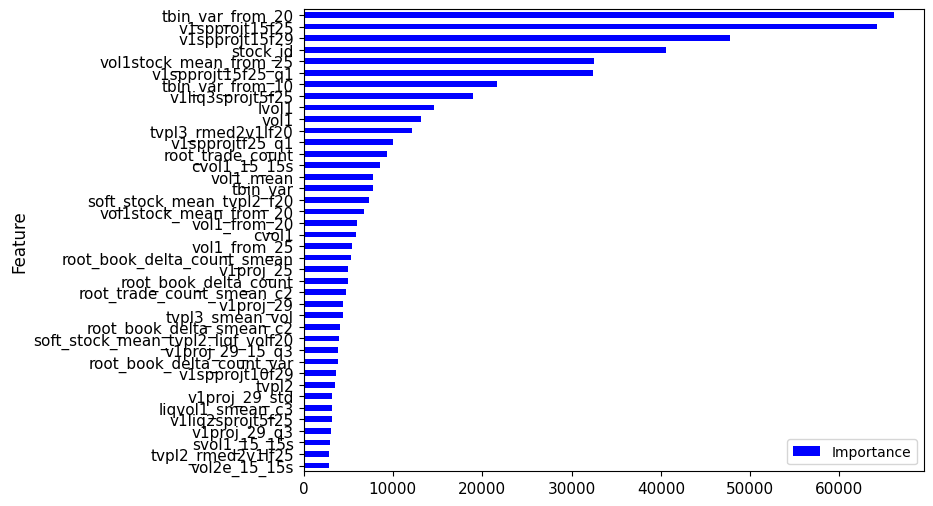

CLUSTER: 1 0.16965393115925134
model
[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\A

Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.19792
[500]	valid_0's RMSPE: 0.19359
[750]	valid_0's RMSPE: 0.1925
[1000]	valid_0's RMSPE: 0.19226
[1250]	valid_0's RMSPE: 0.19209
[1500]	valid_0's RMSPE: 0.1922
Early stopping, best iteration is:
[1228]	valid_0's RMSPE: 0.19203
SCORE: 0.1920345885372992
0.5347157965682703
0.6111830308908435
0.9242719430831708
0.9336913974696159


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model
[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\A

Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.20238
[500]	valid_0's RMSPE: 0.19827
[750]	valid_0's RMSPE: 0.197
[1000]	valid_0's RMSPE: 0.19638
[1250]	valid_0's RMSPE: 0.19603
[1500]	valid_0's RMSPE: 0.19593
[1750]	valid_0's RMSPE: 0.19583
[2000]	valid_0's RMSPE: 0.19576
[2250]	valid_0's RMSPE: 0.19577
Early stopping, best iteration is:
[1972]	valid_0's RMSPE: 0.19575
SCORE: 0.19575496186277644
0.5402017708565973
0.58954231972288
0.9197899474368677
0.9303861937599536


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model
[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\A

Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.20389
[500]	valid_0's RMSPE: 0.19957
[750]	valid_0's RMSPE: 0.19839
[1000]	valid_0's RMSPE: 0.19807
[1250]	valid_0's RMSPE: 0.19787
[1500]	valid_0's RMSPE: 0.19771
[1750]	valid_0's RMSPE: 0.19765
[2000]	valid_0's RMSPE: 0.19767
Early stopping, best iteration is:
[1671]	valid_0's RMSPE: 0.19761
SCORE: 0.19761211110026417
0.5540207266841377
0.601713744216473
0.9236980779873817
0.9316073021751224


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model
[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\A

Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.20254
[500]	valid_0's RMSPE: 0.19844
[750]	valid_0's RMSPE: 0.1974
[1000]	valid_0's RMSPE: 0.19699
[1250]	valid_0's RMSPE: 0.19691
[1500]	valid_0's RMSPE: 0.19684
[1750]	valid_0's RMSPE: 0.19689
Early stopping, best iteration is:
[1467]	valid_0's RMSPE: 0.19682
SCORE: 0.1968244700318008
0.4749972070056288
0.5846997430208389
0.9205137447430225
0.9292991604593125


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


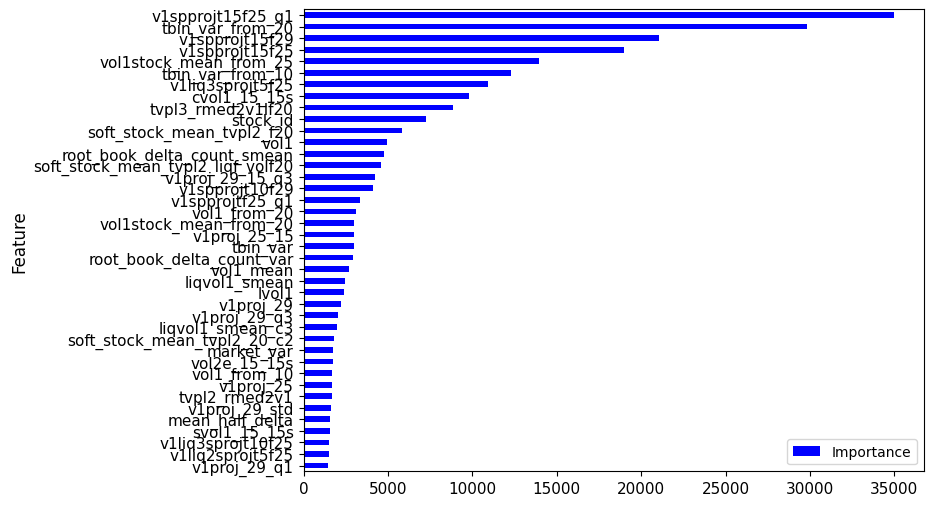

CLUSTER: 2 0.285695634739306
model


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22043
[500]	valid_0's RMSPE: 0.21548
[750]	valid_0's RMSPE: 0.21438
[1000]	valid_0's RMSPE: 0.214
[1250]	valid_0's RMSPE: 0.21374
[1500]	valid_0's RMSPE: 0.21374
[1750]	valid_0's RMSPE: 0.2138
Early stopping, best iteration is:
[1390]	valid_0's RMSPE: 0.2137
SCORE: 0.21370438544912765
0.5697405616311194
0.6399272381800922
0.9283519594346813
0.9338558959916202


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21882
[500]	valid_0's RMSPE: 0.21397
[750]	valid_0's RMSPE: 0.21275
[1000]	valid_0's RMSPE: 0.21226
[1250]	valid_0's RMSPE: 0.21194
[1500]	valid_0's RMSPE: 0.21187
[1750]	valid_0's RMSPE: 0.21186
[2000]	valid_0's RMSPE: 0.21182
[2250]	valid_0's RMSPE: 0.21178
[2500]	valid_0's RMSPE: 0.21185
Early stopping, best iteration is:
[2176]	valid_0's RMSPE: 0.21175
SCORE: 0.21175473459687819
0.5424571876878694
0.6246822674727741
0.9229836924370064
0.9331274577757944


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22117
[500]	valid_0's RMSPE: 0.21654
[750]	valid_0's RMSPE: 0.21557
[1000]	valid_0's RMSPE: 0.21527
[1250]	valid_0's RMSPE: 0.21519
[1500]	valid_0's RMSPE: 0.21531
Early stopping, best iteration is:
[1232]	valid_0's RMSPE: 0.21519
SCORE: 0.21519458687099377
0.5231091538087757
0.636646629606323
0.9186422649364968
0.9342391925545644


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.21932
[500]	valid_0's RMSPE: 0.21566
[750]	valid_0's RMSPE: 0.21462
[1000]	valid_0's RMSPE: 0.21445
[1250]	valid_0's RMSPE: 0.21444
[1500]	valid_0's RMSPE: 0.21461
Early stopping, best iteration is:
[1128]	valid_0's RMSPE: 0.21437
SCORE: 0.21437398175044836
0.5414739966476851
0.6112247096991064
0.9247657113768821
0.9309546958280247


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


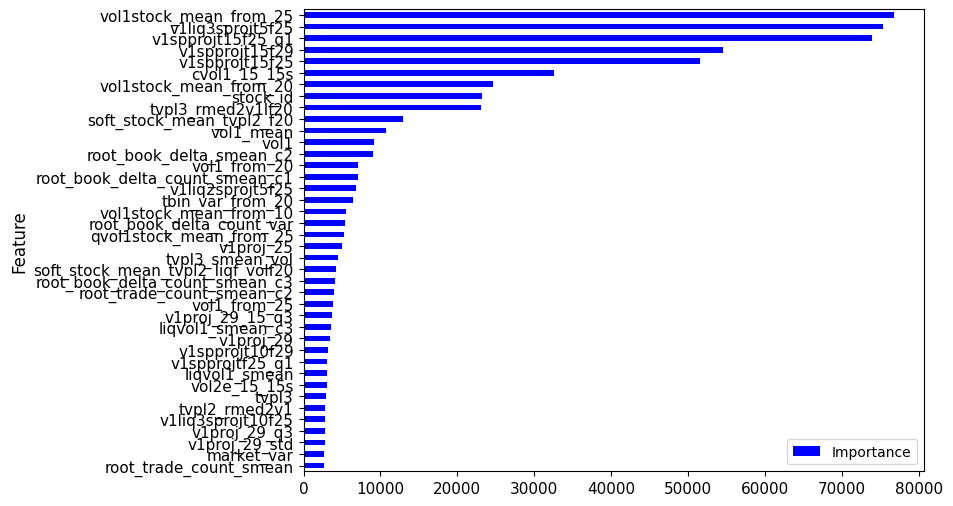

CLUSTER: 3 0.22322652541661617
model
[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\A

Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22875
[500]	valid_0's RMSPE: 0.22437
[750]	valid_0's RMSPE: 0.22434
[1000]	valid_0's RMSPE: 0.22573
Early stopping, best iteration is:
[586]	valid_0's RMSPE: 0.22404
SCORE: 0.2240438947407108
0.4490422457144246
0.5655086124001069
0.9292621658059551
0.9339476546796488


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model
[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\A

Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.2366
[500]	valid_0's RMSPE: 0.23126
[750]	valid_0's RMSPE: 0.2301
[1000]	valid_0's RMSPE: 0.23021
[1250]	valid_0's RMSPE: 0.23047
Early stopping, best iteration is:
[812]	valid_0's RMSPE: 0.22995
SCORE: 0.22995468976645794
0.37165636004244257
0.5419089542587104
0.9215592680709197
0.9298307155764726


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model
[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\A

Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.22927
[500]	valid_0's RMSPE: 0.22459
[750]	valid_0's RMSPE: 0.22329
[1000]	valid_0's RMSPE: 0.22296
[1250]	valid_0's RMSPE: 0.22315
[1500]	valid_0's RMSPE: 0.22314
Early stopping, best iteration is:
[1059]	valid_0's RMSPE: 0.22294
SCORE: 0.22294177337348728
0.5103918942091697
0.585872729464617
0.9326911867037745
0.9375778751736559


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


model
[LightGBM] [Warning] Unknown parameter: seedtvpl3_rmed2v1


c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\samsung\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\samsung\A

Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.25819
[500]	valid_0's RMSPE: 0.25348
[750]	valid_0's RMSPE: 0.25391
[1000]	valid_0's RMSPE: 0.25497
Early stopping, best iteration is:
[589]	valid_0's RMSPE: 0.25321
SCORE: 0.2532123265042516
0.42328312066371304
0.540514202927485
0.9241821989486163
0.9308162230428607


C:\Users\samsung\AppData\Local\Temp\ipykernel_30900\1998036031.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


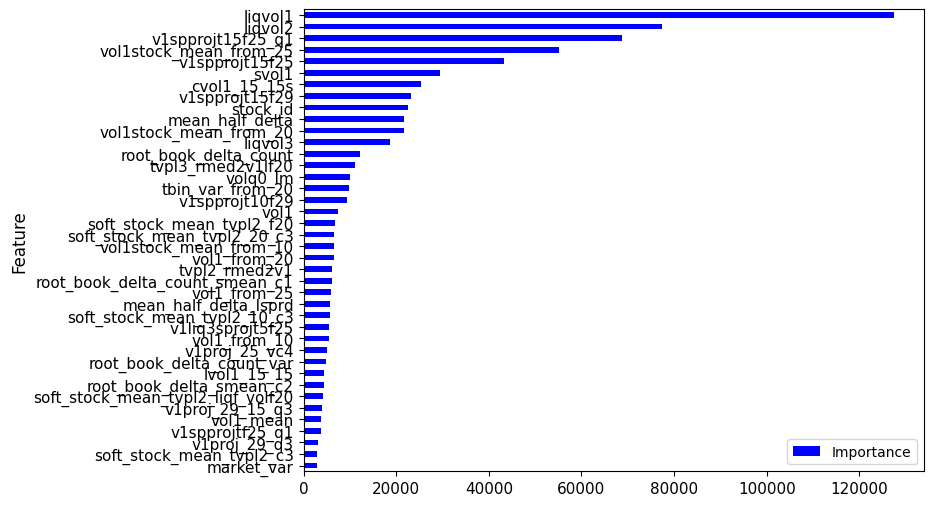

FULL SCORE: 0.21499776882018756


In [8]:
from sklearn.model_selection import KFold


model_name = 'lgbmodel'
pred_name ='lgbpred'

def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

seed1=11


params_lgbm = {
        'learning_rate': 0.01,        
        'lambda_l1': 4,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 256,
        'max_depth': 8,
        'objective': 'regression',
        'metric': 'None',
    
        'seedtvpl3_rmed2v1': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }


cats=['stock_id']


features_to_consider = features + cats   
features_to_consider = list(np.unique(features_to_consider))

test_df['target'] = 0.0

    
gc.collect()
    
n_folds = 4
n_rounds = 5000
kf = model_selection.KFold(n_splits=n_folds, shuffle=False)
scores_folds[model_name] = []
counter = 1

u = np.unique(train['time_id'])


all_models= []

comb_importances = []

cluster_importances = {}

cluster_key= 'lr1_clusters2'
full_score = 0.0
for cluster in range(np.max(train_df[cluster_key])+1):
    models = []

    print('CLUSTER:', cluster, np.mean(train_df[cluster_key]==cluster))
    
    train_cluster = train_df.loc[train_df[cluster_key]==cluster].reset_index(drop=True)
    
    kf = KFold(4)
    
    for ttids, vtids in kf.split(u):
        
        train_batch = train_cluster.loc[train_cluster['time_id'].isin(u[ttids])].reset_index(drop=True)
        val_batch   = train_cluster.loc[train_cluster['time_id'].isin(u[vtids])].reset_index(drop=True)

        
        v1t = np.exp(train_batch['vol1'])
        v1v = np.exp(  val_batch['vol1'])

        X_train = train_batch[features_to_consider]
        y_train = train_batch['target'].values
        w_train = train_batch['target'].values **-2 * v1t**2

        X_val = val_batch[features_to_consider]
        y_val = val_batch['target'].values
        w_val = val_batch['target'].values **-2 * v1v**2


        train_data = lgb.Dataset(X_train, label=y_train/v1t, categorical_feature=cats, weight=w_train)
        val_data   = lgb.Dataset(X_val,   label=  y_val/v1v,   categorical_feature=cats, weight=w_val  )



        print('model')
        model = lgb.train(params_lgbm, 
                          train_data, 
                          n_rounds, 
                          valid_sets=val_data, 
                          feval=feval_RMSPE,

                          verbose_eval= 250,
                          early_stopping_rounds=500)

        models.append(model)
        all_models.append(model)

        p = model.predict(X_val)*v1v
        score =  np.mean( ((p-y_val)/y_val)**2 )**0.5
        
        full_score += y_val.shape[0]*score**2
        
        
        print('SCORE:', score)
        print(nancorr(       p/v1v ,        y_val/v1v ))
        print(nancorr(np.log(p/v1v), np.log(y_val/v1v)))

        print(nancorr(p, y_val))
        print(nancorr(np.log(p), np.log(y_val)))

        
        test_pred = (model.predict(test_df[features_to_consider][test_df[cluster_key]==cluster] )
                                                                 *np.exp(test_df['vol1'][test_df[cluster_key]==cluster]) )
        
        test_df['target'][test_df[cluster_key]==cluster] += test_pred/n_folds


        counter += 1



    importances = pd.DataFrame({'Feature': model.feature_name(), 
                                'Importance': sum( [model.feature_importance(importance_type='gain') for model in models] )})

    cluster_importances[cluster] = importances
    

    importances2 = importances.nlargest(40,'Importance', keep='first').sort_values(by='Importance', ascending=True)
    importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (8,6), color = 'blue', fontsize=11);plt.ylabel('Feature', fontsize=12)
    plt.show()

    
lgbm_importances = pd.DataFrame({'Feature': model.feature_name(), 
                                'Importance': sum( [model.feature_importance(importance_type='gain') for model in all_models] )})
    
del models, all_models
    
    

def importance(feature):
    return importances[importances['Feature'] == feature]

full_score = ( full_score / train_df.shape[0] )**0.5

print('FULL SCORE:', full_score)


## NN Model

In [ ]:
###### https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
import tensorflow as tf
from keras.backend import sigmoid



def swish(x, beta = 1, extrapolation=.667):
    q = (x**2+1)**.5
    qq = q**(1-extrapolation)

    return tf.concat( ( x/qq * (x/q + 1)/2, -x/qq * (-x/q + 1)/2,    x, qq/q),  -1)


from keras import backend as K

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})



def root_mean_squared_per_error(y_true, y_pred):
    return K.sqrt(K.mean( tf.cast(y_true>0,tf.float32) * K.square( (y_true - y_pred)/ (y_true+1e-10))) )
    

stock_embedding_size = 12

cat_data = train['stock_id']

def base_model(n_sids, n_features):
    
    
    stock_embedding_size = 4

    
    stock_id_input = keras.Input(shape=(n_sids,), name='stock_id')

    num_input = keras.Input(shape=(n_sids, n_features), name='num_data')


    x = num_input
    
    xm = tf.math.reduce_mean(x, axis=(0), keepdims=True)
    xs = tf.math.reduce_std( x, axis=(0), keepdims=True)
                            

                            
    x = x - xm
    x = x / (xs + 1e-12)
    
    xs = keras.layers.Concatenate()((xm, xs)) 
    xs = keras.layers.Dense(16)(xs)
    x = keras.layers.Concatenate()((x, xs + 0*x[:,:,:1])) 
    
    
    
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)


    x = keras.layers.GaussianNoise(.05)(x)
    x = keras.layers.Concatenate()([stock_embedded, x])

        

    hidden_units = ( 256,128,64,32)
    extrapolations = (.75, .75, .6, .45, .45)
    dropouts = (0.15, 0.00, 0.0, 0., 0.)
    
    
    for k in range(len(hidden_units)):
        x = keras.layers.Dense(hidden_units[k], activation='linear')(x)
        if dropouts[k] > 0:
            x = keras.layers.Dropout(dropouts[k])(x)
        x = swish(x, beta=1, extrapolation= extrapolations[k])
    
    q = keras.layers.Dense(16)(x)
    
    q = tf.transpose(q, [0,2,1])
    q = keras.layers.SpatialDropout1D(.25)(q)
    q = tf.transpose(q, [0,2,1])
 
    q = swish(q, extrapolation=0.85)

    
    q = keras.layers.Flatten()(q)
        
    q = keras.layers.Dense(64)(q)
    q = keras.layers.Dropout(.25)(q)  
    q = swish(q, beta=1)
    
    
    q = keras.layers.Dense(32)(q)
    q = swish(q, beta=1,extrapolation=.6)
    
    
    q = keras.layers.Dense(n_sids)(q)
    q = keras.layers.Reshape([n_sids, 1])(q)
    

    out = keras.layers.Dense(1, activation='linear', name='prediction')(x) +  q
    
        
    model = keras.Model(
    inputs = [stock_id_input,  num_input],
    outputs = out,
    )
    
    return model

In [ ]:
def low_reg_model(n_sids, n_features):
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    
    stock_embedding_size = 4

    
    stock_id_input = keras.Input(shape=(n_sids,), name='stock_id')

    num_input = keras.Input(shape=(n_sids, n_features), name='num_data')

    x = num_input

    
    xm = tf.math.reduce_mean(x, axis=(0), keepdims=True)
    xs = tf.math.reduce_std( x, axis=(0), keepdims=True)
                                                        
    x = x - xm
    x = x / (xs + 1e-12)
    
    xs = keras.layers.Concatenate()((xm, xs)) 
    xs = keras.layers.Dense(16)(xs)
    x = keras.layers.Concatenate()((x, xs + 0*x[:,:,:1])) 
    
    
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)


    x = keras.layers.GaussianNoise(.05)(x)

    
    x = keras.layers.Concatenate()([stock_embedded, x])

        

    hidden_units = ( 256,128,64,32)
    extrapolations = (.75, .75, .6, .45, )
    dropouts = (0.25, 0.0, 0.0, 0.0,)
    
    
    for k in range(len(hidden_units)):
        x = keras.layers.Dense(hidden_units[k], activation='linear')(x)
        if dropouts[k] > 0:
            x = keras.layers.Dropout(dropouts[k])(x)
        x = swish(x, beta=1, extrapolation= extrapolations[k])
        
    
    
    q = keras.layers.Dense(16)(x)
    
    q = tf.transpose(q, [0,2,1])
    q = keras.layers.SpatialDropout1D(.25)(q)
    q = tf.transpose(q, [0,2,1])
 
    q = swish(q, extrapolation=0.85)

    
    q = keras.layers.Flatten()(q)
    
    
    q = keras.layers.Dense(64)(q)
    q = keras.layers.Dropout(.25)(q)  
    q = swish(q, beta=1)
    
    
    q = keras.layers.Dense(32)(q)
    q = swish(q, beta=1,extrapolation=.6)
    
    
    q = keras.layers.Dense(n_sids)(q)
    q = keras.layers.Reshape([n_sids, 1])(q)
    

    out = keras.layers.Dense(1, activation='linear', name='prediction')(x) +  q
        
    model = keras.Model(
    inputs = [stock_id_input,  num_input],
    outputs = out,
    )
    
    return model

## Training

In [ ]:
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

def set_field_from_dict(fdict, df, field_name):

    T = fdict['time_ids']
    S = fdict['stock_ids']
    R = fdict[field_name]
    
    R = np.reshape( R, [R.shape[0]*R.shape[1]] )
    S = np.reshape( S, [S.shape[0]*S.shape[1]] )
    T = np.reshape( T, [T.shape[0]*T.shape[1]] )

    dfz = pd.DataFrame(data=np.vstack([S,T,R]  ).T, columns=['stock_id', 'time_id',field_name])

    dfz['time_id' ] = dfz['time_id' ].astype(int)
    dfz['stock_id'] = dfz['stock_id'].astype(int)

    dfz = df.merge(dfz, on=['stock_id', 'time_id'], how='left')
    return dfz

def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean((y_true>0)*np.square((y_true - y_pred) / (y_true+1e-10) )))


es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=25, verbose=0,
    mode='min',restore_best_weights=False)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.15, patience=8, verbose=0,
    mode='min')

model_name = 'full_model'
pred_name = model_name + '_pred'

gc.collect()
    
n_folds = 4
    
X_test = keys_to_array(test_feat, features)
X_test[np.isnan(X_test)] = 0
X_test[X_test<-10000] = -10000
X_test[X_test> 10000] =  10000
    
v_test = np.exp(test_feat['vol1'])
S_test = test_feat['stock_ids']  

test_feat[pred_name] = 0*v_test
                               
    
    
X = keys_to_array(train_feat, features)

full_score=0
kf = KFold(n_folds)
for ti,vi in kf.split(X):
    
        
    X_train = X[ti,:,:]
    v_train = np.exp(train_feat['vol1'][ti,:,:])
    S_train = train_feat['stock_ids'][ti,:,:]   
    y_train = train_feat['target'][ti,:]
    
    X_val = X[vi,:,:]
    v_val = np.exp(train_feat['vol1'][vi,:,:])
    S_val = train_feat['stock_ids'][vi,:,:]   
    y_val = train_feat['target'][vi,:]

    
    X_train[np.isnan(X_train)] = 0
    X_val[  np.isnan(X_val)  ] = 0
    
    X_train[X_train<-10000] = -10000
    X_val[  X_val  <-10000] = -10000
    
    X_train[X_train>10000] = 10000
    X_val[  X_val  >10000] = 10000

 
    
    Xm = np.median(    X_train, axis=(0,1), keepdims=True)
    Xs = (np.quantile( X_train, .84, axis=(0,1), keepdims=True) - np.quantile( X_train, .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    ym = np.median(    np.log(y_train + 1e-12),      axis=(0,1), keepdims=True)
    ys = (np.quantile( np.log(y_train + 1e-12), .84, axis=(0,1), keepdims=True) - np.quantile( np.log(y_train), .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    
    
    X_train = (X_train - Xm)/Xs
    X_val   = (X_val   - Xm)/Xs
    
    X_train = np.tanh(X_train/5)*5
    X_val   = np.tanh(X_val  /5)*5
 
    model1= base_model(X_train.shape[1], X_train.shape[2])
    
    model1.compile(
        keras.optimizers.RMSprop(learning_rate=0.005, rho=.9),

        loss=root_mean_squared_per_error
    )
        
    
    model1.fit([S_train, X_train], 
              y_train[:,:,np.newaxis]/v_train,               
              batch_size=64,
              epochs=300, 
              validation_data=([S_val, X_val], y_val[:,:,np.newaxis]/v_val),
              callbacks=[es, plateau],
              validation_batch_size=y_val.shape[0],
              shuffle=True,
             verbose = 2)
 
   
    preds = (model1.predict([S_val,  X_val], batch_size=X_val.shape[0]))
    
    
    
    score = rmspe(y_val[:,:,np.newaxis], preds*v_val)
   
    full_score += score**2

    print('SCORE:', score)
    

    test_pred = (model1.predict([ S_test,  np.tanh((X_test - Xm)/Xs/5)*5], batch_size=X_test.shape[0]) )*v_test

    test_feat[pred_name] = test_feat[pred_name] + test_pred/n_folds
    
    gc.collect()
    
full_score = (full_score/n_folds)**0.5

print('FULL SCORE', full_score)




if IS_GOOD_TEST:
    test       = set_field_from_dict(test_feat,       test, pred_name)
else:
    dummy_test = set_field_from_dict(test_feat, dummy_test, pred_name)
    



In [ ]:
model_name = 'select_model'

pred_name = model_name + '_pred'

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.15, patience=7, verbose=0,
    mode='min')

gc.collect()
    
n_folds = 4
kf = model_selection.KFold(n_splits=n_folds, shuffle=False)
counter = 1


select_features = lgbm_importances.nlargest(40,'Importance', keep='first').sort_values(by='Importance', ascending=True)
select_features = list(select_features['Feature'])
select_features.remove('stock_id')
    

X_test = keys_to_array(test_feat, select_features)
X_test[np.isnan(X_test)] = 0
X_test[X_test<-10000] = -10000
X_test[X_test> 10000] =  10000
    
v_test = np.exp(test_feat['vol1'])
S_test = test_feat['stock_ids']  
test_feat[pred_name] = 0*v_test
                       
                               
X = keys_to_array(train_feat, select_features)

full_score=0
kf = KFold(n_folds)
for ti,vi in kf.split(X):
    
    print(ti.shape[0], vi.shape[0], X.shape[0])
        
    X_train = X[ti,:,:]
    v_train = np.exp(train_feat['vol1'][ti,:,:])
    S_train = train_feat['stock_ids'][ti,:,:]   
    y_train = train_feat['target'][ti,:]
    
    X_val = X[vi,:,:]
    v_val = np.exp(train_feat['vol1'][vi,:,:])
    S_val = train_feat['stock_ids'][vi,:,:]   
    y_val = train_feat['target'][vi,:]

    
    X_train[np.isnan(X_train)] = 0
    X_val[  np.isnan(X_val)  ] = 0
    
    X_train[X_train<-10000] = -10000
    X_val[  X_val  <-10000] = -10000
    
    X_train[X_train>10000] = 10000
    X_val[  X_val  >10000] = 10000

    
    Xm = np.median(    X_train,      axis=(0,1), keepdims=True)
    Xs = (np.quantile( X_train, .84, axis=(0,1), keepdims=True) - np.quantile( X_train, .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    ym = np.median(    np.log(y_train + 1e-12),      axis=(0,1), keepdims=True)
    ys = (np.quantile( np.log(y_train + 1e-12), .84, axis=(0,1), keepdims=True) - np.quantile( np.log(y_train), .16, axis=(0,1), keepdims=True))/2 + 1e-8
    
    
    X_train = (X_train - Xm)/Xs
    X_val   = (X_val   - Xm)/Xs
    
    X_train = np.tanh(X_train/5)*5
    X_val   = np.tanh(X_val  /5)*5


    
    model1= low_reg_model(X_train.shape[1], X_train.shape[2])
    
    model1.compile(
        keras.optimizers.RMSprop(learning_rate=0.005, rho=.9),

        loss=root_mean_squared_per_error
    )
        
    model1.fit([S_train, X_train], 
              y_train[:,:,np.newaxis]/v_train,               
              batch_size=64,
              epochs=200, 
              validation_data=([S_val, X_val], y_val[:,:,np.newaxis]/v_val),
              callbacks=[es, plateau],
              validation_batch_size=y_val.shape[0],
              shuffle=True,
             verbose = 2)
 
   
    preds = (model1.predict([S_val,  X_val], batch_size=X_val.shape[0]))
        
    score = rmspe(y_val[:,:,np.newaxis], preds*v_val)
   
    full_score += score**2

    print('SCORE:', score)
    

    test_pred = (model1.predict([ S_test,  np.tanh((X_test - Xm)/Xs/5)*5], batch_size=X_test.shape[0]) )*v_test


    
    test_feat[pred_name] = test_feat[pred_name] + test_pred/n_folds

    
    gc.collect()
    
full_score = (full_score/n_folds)**0.5

print('FULL SCORE', full_score)




if IS_GOOD_TEST:
    test = set_field_from_dict(test_feat, test, pred_name)
else:
    dummy_test = set_field_from_dict(test_feat, dummy_test, pred_name)
    
    
    
    
if IS_GOOD_TEST:
    test['target']       = 0.6*      test['full_model_pred'] + 0.4*      test['select_model_pred']
else:
    dummy_test['target'] = 0.6*dummy_test['full_model_pred'] + 0.4*dummy_test['select_model_pred']
  
    
    print(dummy_test)
    print(dummy_test.columns)
    comb_test = dummy_test.merge(train, on=['time_id','stock_id'], how='right')
    comb_test['target_y'] = 1.0*comb_test['target_y']
    
    print(comb_test.columns)
    
    print('TEST SCORE:', np.mean( (  (comb_test['target_x']-comb_test['target_y'])/comb_test['target_y']  )**2)**0.5)
    
    test['target'] = 0

    
    
    
test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)

print(test)

test[['row_id', 'target']].to_csv('submission.csv',index = False)